# Leave out one

In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re

In [2]:
filename = "./data/colima/colima_real_data.csv"

raw_df = pd.read_csv(filename)

phi_labels = [
    "[-5,-4)",
    "[-4,-3)" ,
    "[-3,-2)",
    "[-2,-1)",
    "[-1,0)",
    "[0,1)",
    "[1,2)",
    "[2,3)",
    "[3,4)"
]

ventx = 645110
venty = 2158088

raw_df["Easting"] = raw_df["Easting"] - ventx
raw_df["Northing"] = raw_df["Northing"] - venty

for phi in phi_labels:
    raw_df[phi] = (raw_df[phi].values)*100
    
raw_df["radius"] = np.sqrt(raw_df["Easting"]**2 + raw_df["Northing"]**2)

display(raw_df.head())

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
0,VF95-06a,3133,9522,417.20,40,0.0,11.0,21.0,22.0,23.0,17.0,4.0,0.0,0.0,10024.179418
1,VF95-08a,1907,8096,312.90,30,1.0,13.0,19.0,24.0,25.0,16.0,3.0,0.0,0.0,8317.563646
2,VF97-20Q,5500,8723,208.60,20,2.0,7.0,14.0,21.0,26.0,21.0,6.0,1.0,1.0,10312.164128
3,VF98-01a3,2665,9054,239.89,23,4.0,13.0,18.0,21.0,23.0,15.0,3.0,0.0,0.0,9438.068711
4,VF98-02a,1154,7735,156.45,15,1.0,12.0,19.0,23.0,24.0,17.0,3.0,0.0,0.0,7820.610015


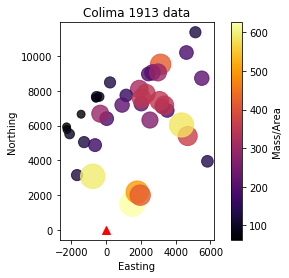

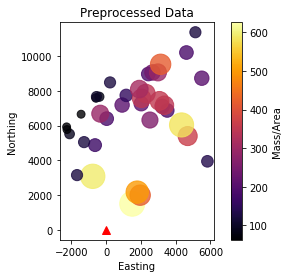

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()
obs_df["radius"] = np.sqrt(obs_df["Easting"]**2 + obs_df["Northing"]**2)

obs_df = obs_df.sort_values(by=['radius'])\

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

# Uncomment to drop proximal points
# obs_df = obs_df[obs_df["radius"]>3500]

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [4]:
grid = obs_df[["Easting", "Northing"]].copy()
grid["Elevation"] = np.zeros(len(grid))
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

# Order of these 3 commands matter
t2_df["radius"] = np.sqrt(t2_df["Easting"]**2 + t2_df["Northing"]**2)
t2_df = t2_df.sort_values(by=['radius'])
t2_df["Residual"] = t2_df["MassArea"]/obs_df["MassArea"]*100

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,0,833.032,17.3819,20.9560,20.9332,17.7376,12.6550,6.92374,2.59392,0.692536,0.126138,2124.861643,133.114733
18,1957,1997,0,695.129,17.3999,21.2760,20.9644,17.4749,12.3856,6.83364,2.73539,0.781439,0.148918,2796.043276,166.617689
17,1787,2173,0,694.558,17.5614,21.4823,21.1019,17.4671,12.2469,6.65295,2.61205,0.736269,0.139112,2813.413940,138.734020
37,-770,3082,0,227.391,14.1129,18.5440,20.7423,19.3846,14.6875,8.27902,3.20274,0.881546,0.165408,3176.731654,38.248474
31,-1673,3152,0,100.136,11.3118,15.5037,19.2828,20.3236,17.0715,10.53570,4.42227,1.293020,0.255589,3568.477687,80.006392


In [5]:
config = {}
with open("data/colima/colima_config.txt") as f:
    for line in f:
        line = line.strip()
        if not line=="" and not line.startswith("#"):
            (key, val) = line.split()
            config[str(key)] = float(val)

config["COL_STEPS"] = int(config["COL_STEPS"])
config["PART_STEPS"] = int(config["PART_STEPS"])

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}



# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 645110.0,
 'VENT_NORTHING': 2158088.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-4.5,1024.0,"[-5,-4)",-5.0,0.068338,-4.0
1,-3.5,1024.0,"[-4,-3)",-4.0,0.109203,-3.0
2,-2.5,1024.0,"[-3,-2)",-3.0,0.146694,-2.0
3,-1.5,1024.0,"[-2,-1)",-2.0,0.165650,-1.0
4,-0.5,1024.0,"[-1,0)",-1.0,0.157243,0.0


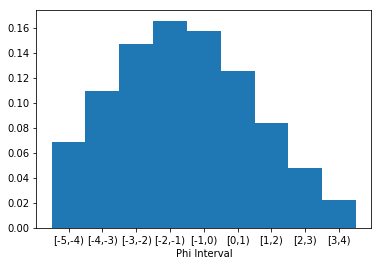

In [6]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps).head())



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [7]:

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)

forward_df = gaussian_stack_forward(
        config, globs, grid, int(config["COL_STEPS"]), 0, 
        config["PLUME_HEIGHT"], phi_steps, q_dist, config["ERUPTION_MASS"], (u,v)
    )

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"]/obs_df["MassArea"]*100
display(forward_df.head())

,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,1506,1499,14.662719,21.477998,23.539136,19.738045,12.911090,6.004510,1.483327,0.176485,0.006689,1198.607874,2124.861643,287.298148
1,1997,1957,12.230719,20.077097,23.726699,20.663027,13.960236,6.966140,2.072407,0.291357,0.012318,1005.835755,2796.043276,321.455978
2,2173,1787,12.123985,20.006264,23.736202,20.718095,14.012231,7.001938,2.093069,0.295676,0.012540,1024.563441,2813.413940,491.161765
3,3082,-770,12.554313,20.438257,23.932389,20.448488,13.450774,6.659616,2.162336,0.338322,0.015505,404.939158,3176.731654,168.802017
4,3152,-1673,12.594545,20.611603,24.181124,20.493127,13.155693,6.344995,2.210467,0.388875,0.019571,193.246416,3568.477687,123.519601


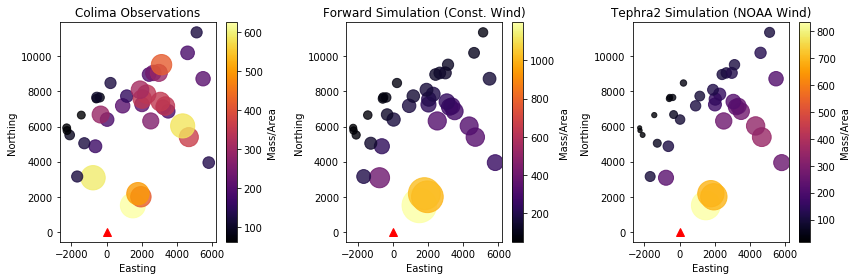

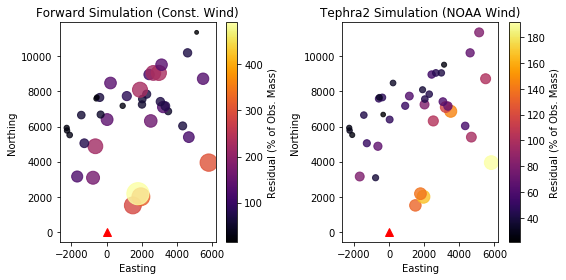

In [8]:
fig, axs = plt.subplots(1,3, figsize=(
        12,4), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(obs_df, vent=(0,0), log=False, 
            title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(forward_df, vent=(0,0), log=False, 
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[2])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2, figsize=(
        8,4), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(forward_df, vent=(0,0), log=False, values="Residual",
            title="Forward Simulation (Const. Wind)", cbar_label="Residual (% of Obs. Mass)", ax=axs[0])
vis.plot_sample(t2_df, vent=(0,0), log=False, values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Residual (% of Obs. Mass)", ax=axs[1])


plt.tight_layout()
plt.show()

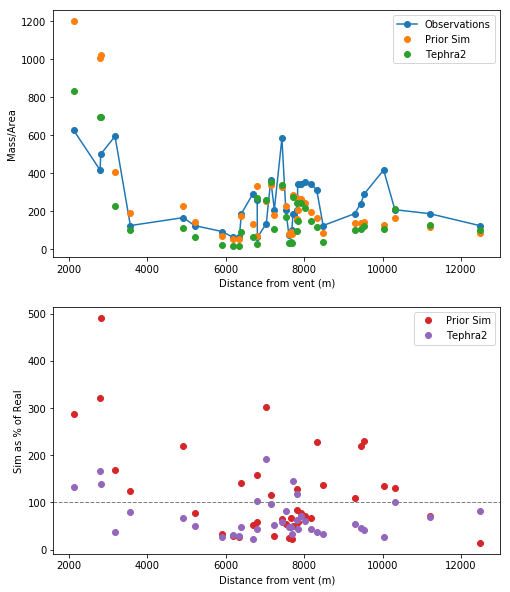

In [9]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()


axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Prior Sim")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C2o', label="Tephra2")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values, 'C3o', label="Prior Sim")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values, 'C4o', label="Tephra2")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========LEFT OUT: (1499.0, 1506.0)========
a* = -2.00286	b* = -2.83191            	h0* = -1.52718	h1* = 1.49994
a = 1.13495	b = 1.05890	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 70
SSE: 320.02636306926007


,Height,Suspended Mass
0,1200.0,2.298432e+09
1,2400.0,2.515778e+09
2,3600.0,2.648338e+09
3,4800.0,2.743361e+09
4,6000.0,2.816502e+09
5,7200.0,2.874952e+09
6,8400.0,2.922599e+09
7,9600.0,2.961745e+09
8,10800.0,2.993814e+09
9,12000.0,3.019686e+09


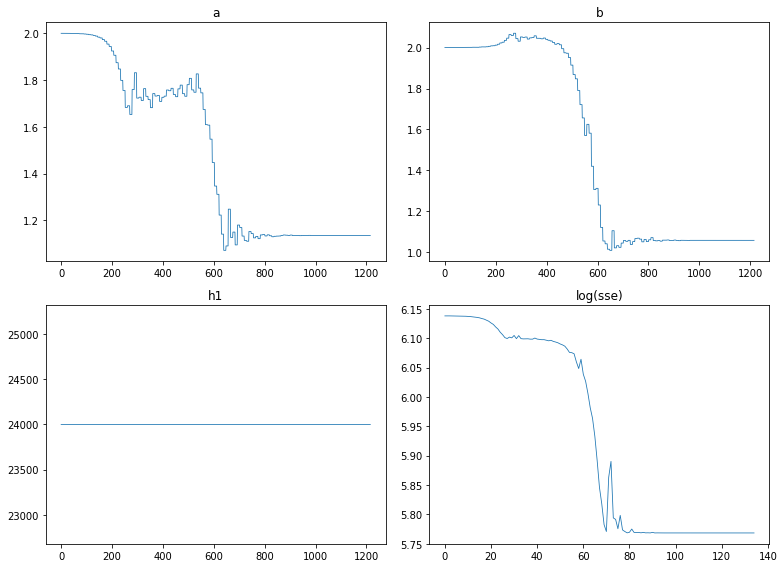

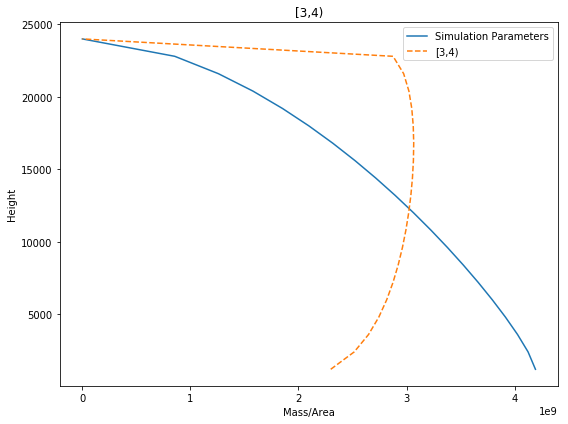

========LEFT OUT: (1957.0, 1997.0)========
a* = -1.99824	b* = -2.83588            	h0* = -1.52718	h1* = 1.49994
a = 1.13557	b = 1.05867	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 71
SSE: 319.04299194745425


,Height,Suspended Mass
0,1200.0,2.294903e+09
1,2400.0,2.513036e+09
2,3600.0,2.646157e+09
3,4800.0,2.741633e+09
4,6000.0,2.815162e+09
5,7200.0,2.873958e+09
6,8400.0,2.921921e+09
7,9600.0,2.961360e+09
8,10800.0,2.993707e+09
9,12000.0,3.019843e+09


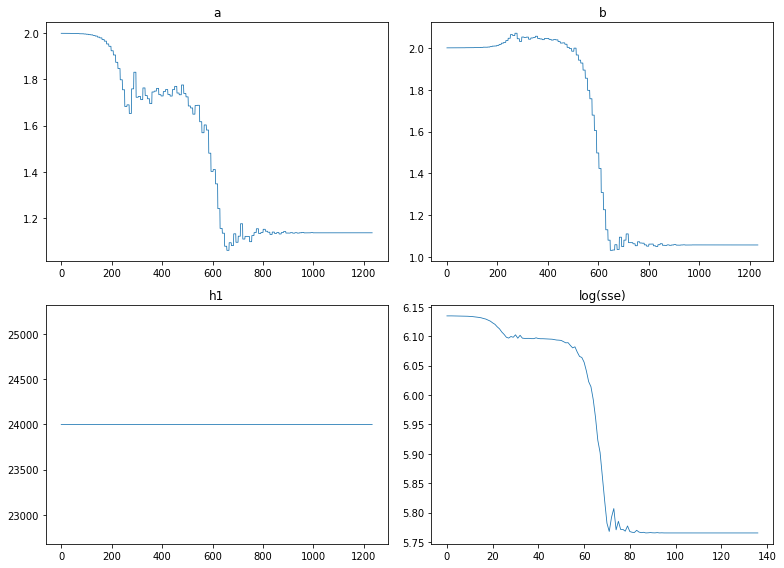

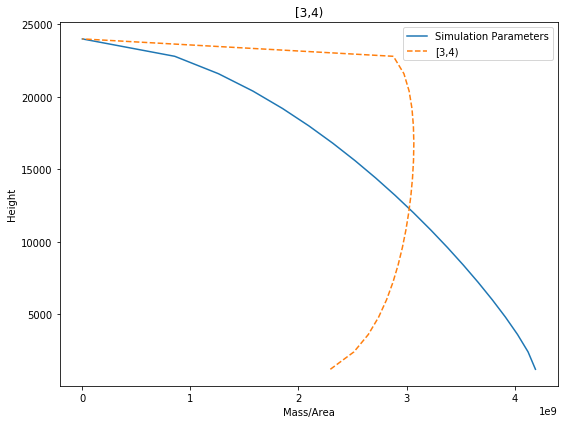

========LEFT OUT: (1787.0, 2173.0)========
a* = -2.03143	b* = -2.81350            	h0* = -1.52718	h1* = 1.49994
a = 1.13115	b = 1.05999	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 69
SSE: 316.362377859546


,Height,Suspended Mass
0,1200.0,2.319315e+09
1,2400.0,2.531808e+09
2,3600.0,2.660943e+09
3,4800.0,2.753223e+09
4,6000.0,2.824031e+09
5,7200.0,2.880423e+09
6,8400.0,2.926209e+09
7,9600.0,2.963639e+09
8,10800.0,2.994103e+09
9,12000.0,3.018453e+09


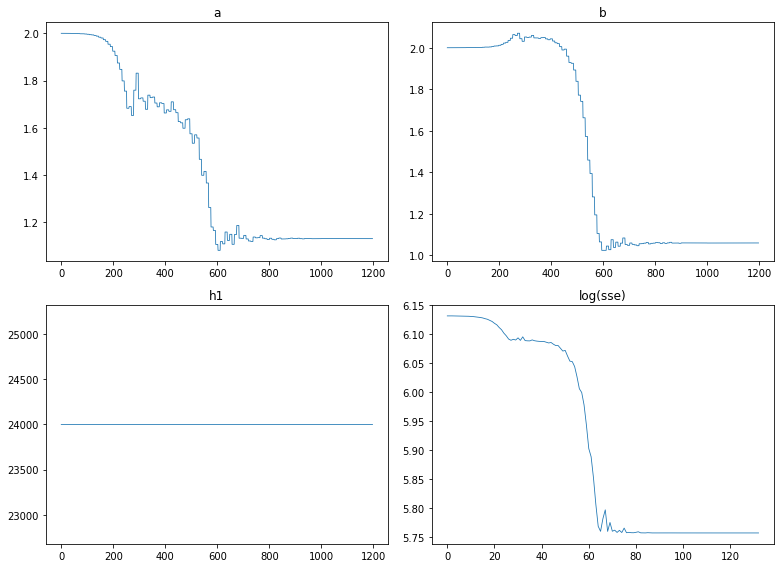

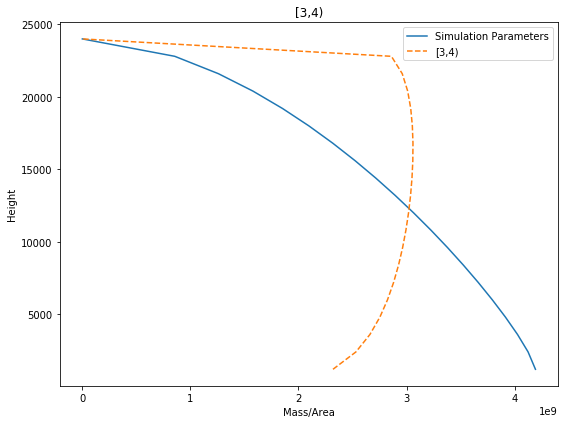

========LEFT OUT: (-770.0, 3082.0)========
a* = -2.00125	b* = -2.83326            	h0* = -1.52718	h1* = 1.49994
a = 1.13517	b = 1.05882	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 70
SSE: 319.8065508255299


,Height,Suspended Mass
0,1200.0,2.297203e+09
1,2400.0,2.514824e+09
2,3600.0,2.647581e+09
3,4800.0,2.742762e+09
4,6000.0,2.816038e+09
5,7200.0,2.874609e+09
6,8400.0,2.922366e+09
7,9600.0,2.961614e+09
8,10800.0,2.993780e+09
9,12000.0,3.019743e+09


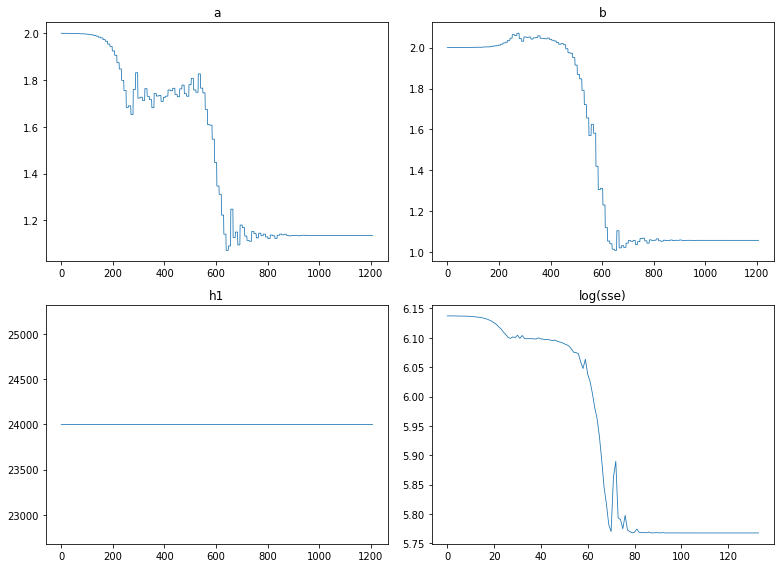

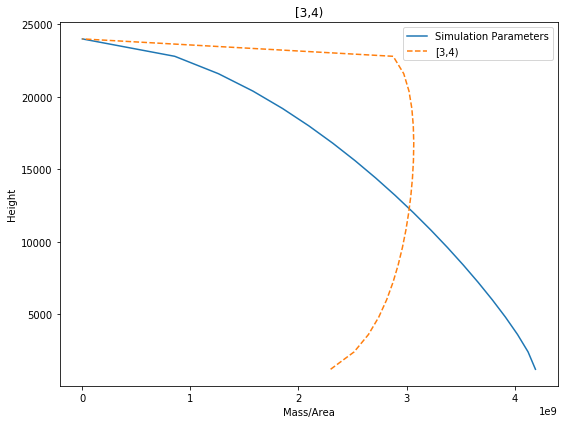

========LEFT OUT: (-1673.0, 3152.0)========
a* = -1.99488	b* = -2.83875            	h0* = -1.52718	h1* = 1.49994
a = 1.13603	b = 1.05850	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 71
SSE: 319.2503297860231


,Height,Suspended Mass
0,1200.0,2.292333e+09
1,2400.0,2.511038e+09
2,3600.0,2.644569e+09
3,4800.0,2.740376e+09
4,6000.0,2.814188e+09
5,7200.0,2.873236e+09
6,8400.0,2.921429e+09
7,9600.0,2.961082e+09
8,10800.0,2.993630e+09
9,12000.0,3.019959e+09


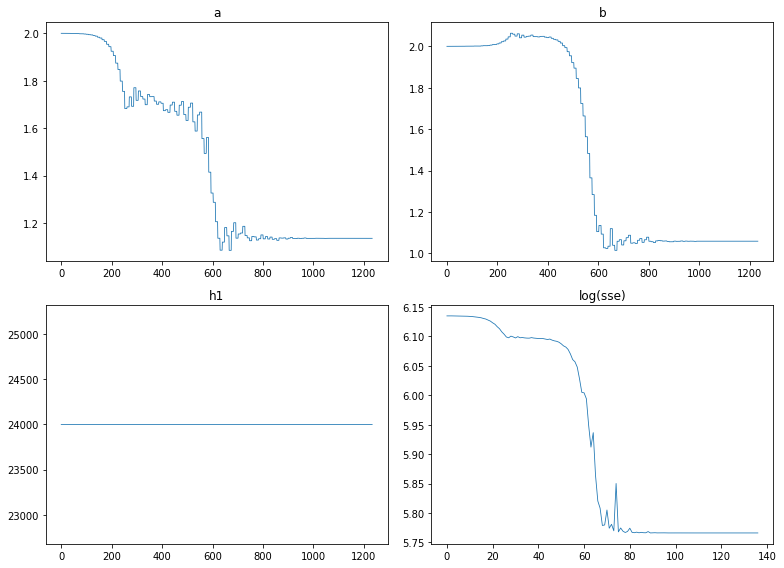

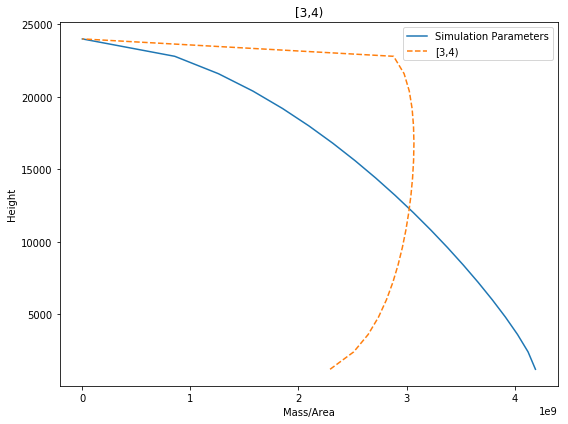

========LEFT OUT: (-637.0, 4876.0)========
a* = -1.99892	b* = -2.83369            	h0* = -1.52718	h1* = 1.49994
a = 1.13548	b = 1.05880	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 69
SSE: 321.8881676774349


,Height,Suspended Mass
0,1200.0,2.295619e+09
1,2400.0,2.513641e+09
2,3600.0,2.646677e+09
3,4800.0,2.742078e+09
4,6000.0,2.815537e+09
5,7200.0,2.874267e+09
6,8400.0,2.922165e+09
7,9600.0,2.961541e+09
8,10800.0,2.993823e+09
9,12000.0,3.019894e+09


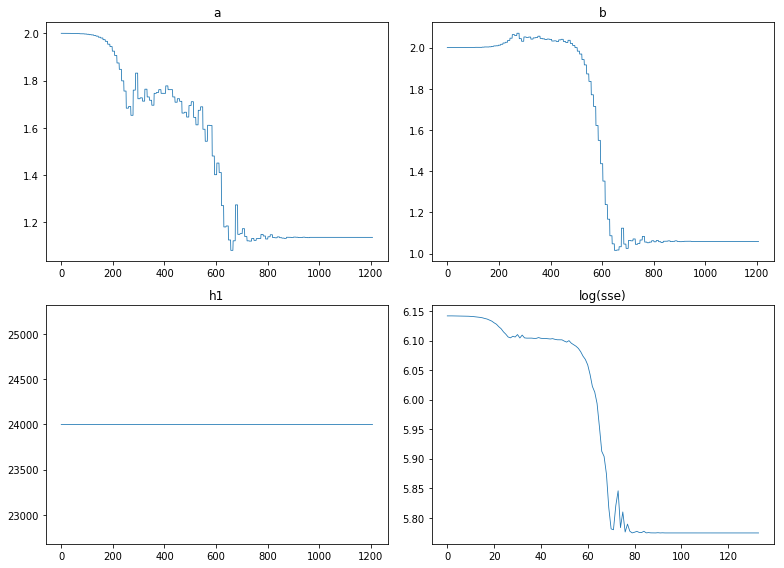

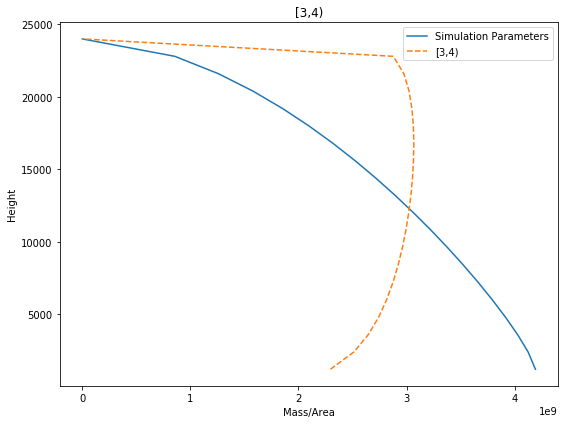

========LEFT OUT: (-1268.0, 5048.0)========
a* = -1.99053	b* = -2.84271            	h0* = -1.52718	h1* = 1.49994
a = 1.13662	b = 1.05827	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 74
SSE: 318.61285121204133


,Height,Suspended Mass
0,1200.0,2.288968e+09
1,2400.0,2.508416e+09
2,3600.0,2.642478e+09
3,4800.0,2.738715e+09
4,6000.0,2.812897e+09
5,7200.0,2.872275e+09
6,8400.0,2.920769e+09
7,9600.0,2.960702e+09
8,10800.0,2.993516e+09
9,12000.0,3.020099e+09


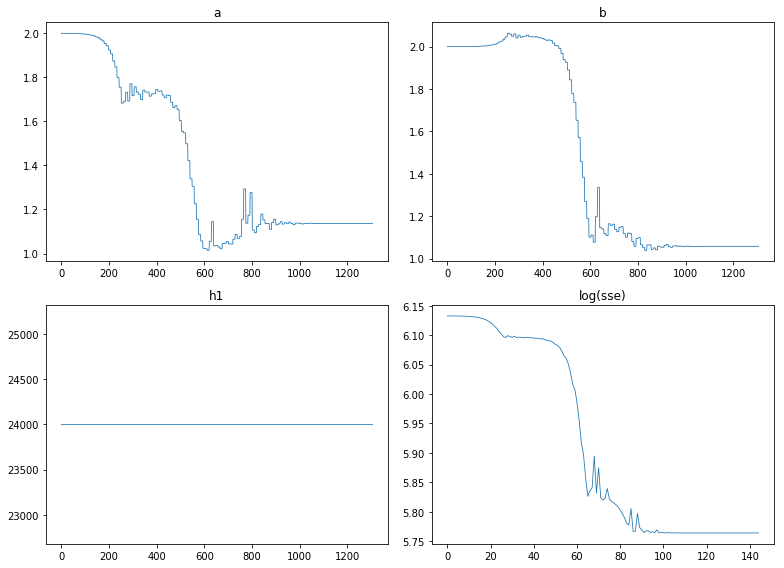

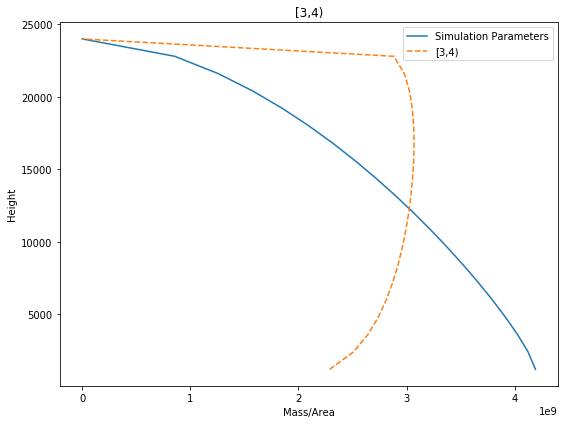

========LEFT OUT: (-2101.0, 5517.0)========
a* = -1.99326	b* = -2.84012            	h0* = -1.52718	h1* = 1.49994
a = 1.13625	b = 1.05842	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 75
SSE: 318.5337174722313


,Height,Suspended Mass
0,1200.0,2.291093e+09
1,2400.0,2.510075e+09
2,3600.0,2.643803e+09
3,4800.0,2.739770e+09
4,6000.0,2.813719e+09
5,7200.0,2.872889e+09
6,8400.0,2.921193e+09
7,9600.0,2.960949e+09
8,10800.0,2.993594e+09
9,12000.0,3.020016e+09


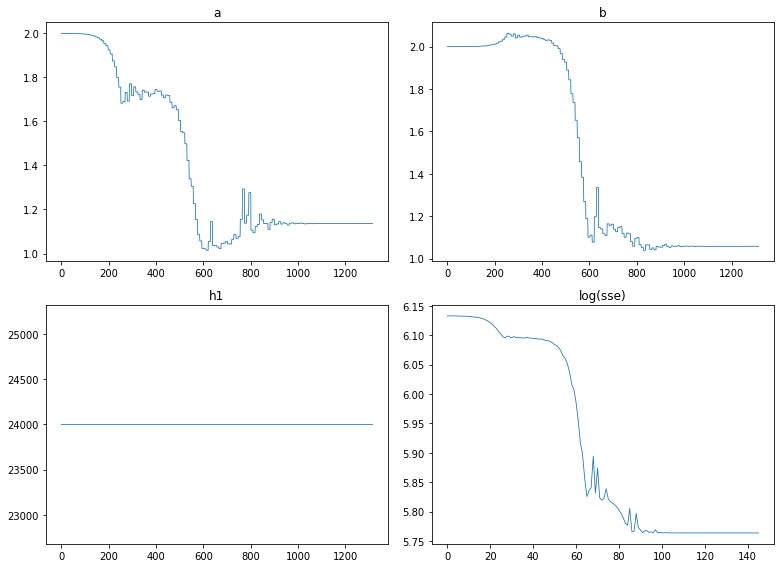

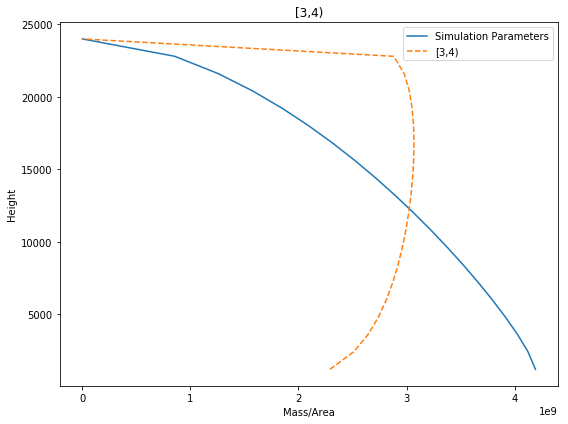

========LEFT OUT: (-2250.0, 5771.0)========
a* = -2.00005	b* = -2.83426            	h0* = -1.52718	h1* = 1.49994
a = 1.13533	b = 1.05876	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 71
SSE: 319.8769258583285


,Height,Suspended Mass
0,1200.0,2.296293e+09
1,2400.0,2.514117e+09
2,3600.0,2.647019e+09
3,4800.0,2.742318e+09
4,6000.0,2.815694e+09
5,7200.0,2.874354e+09
6,8400.0,2.922192e+09
7,9600.0,2.961516e+09
8,10800.0,2.993753e+09
9,12000.0,3.019784e+09


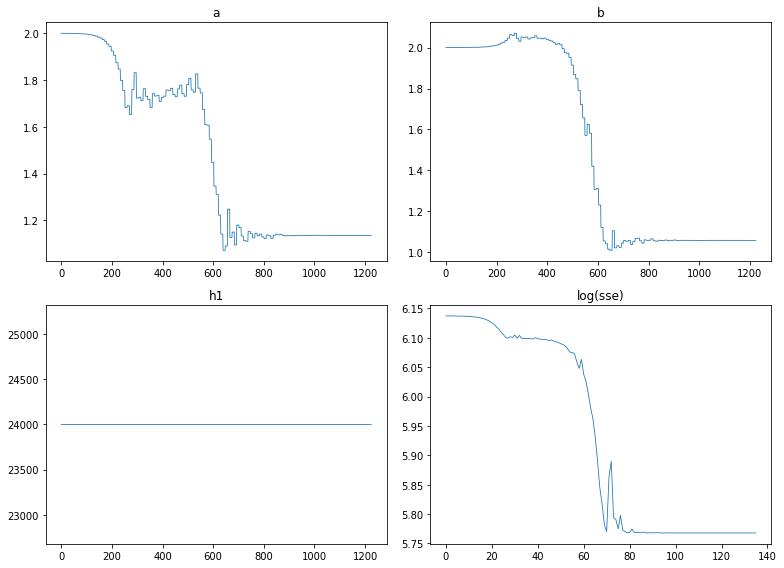

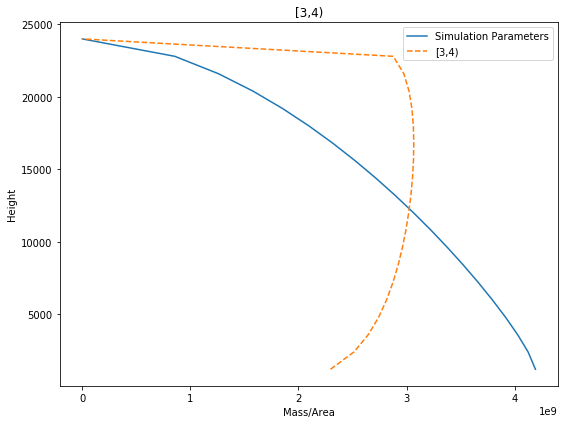

========LEFT OUT: (-2272.0, 5925.0)========
a* = -2.01026	b* = -2.82653            	h0* = -1.52718	h1* = 1.49994
a = 1.13395	b = 1.05922	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 68
SSE: 319.5432519105432


,Height,Suspended Mass
0,1200.0,2.303943e+09
1,2400.0,2.520031e+09
2,3600.0,2.651698e+09
3,4800.0,2.746003e+09
4,6000.0,2.818531e+09
5,7200.0,2.876439e+09
6,8400.0,2.923594e+09
7,9600.0,2.962285e+09
8,10800.0,2.993927e+09
9,12000.0,3.019391e+09


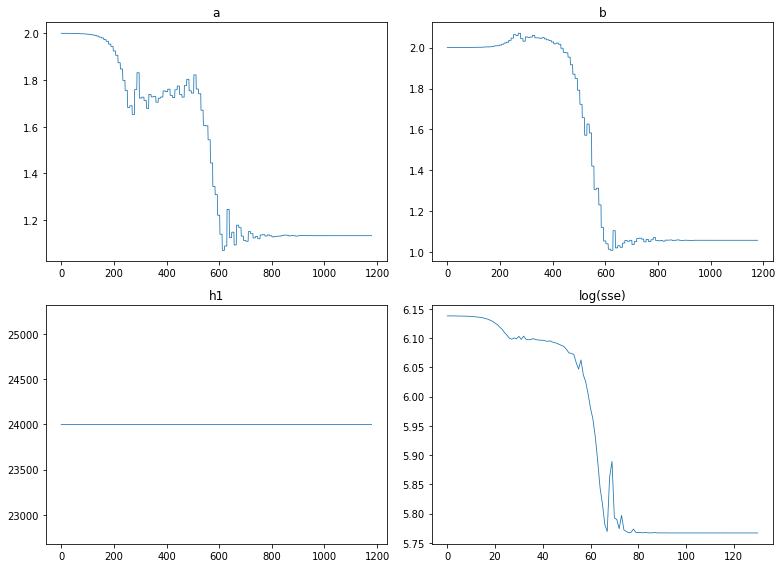

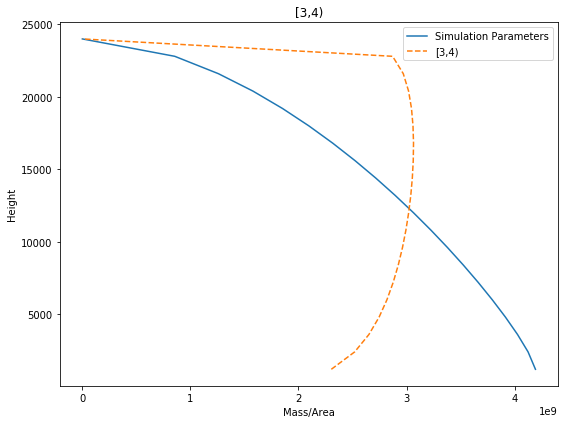

========LEFT OUT: (32.0, 6398.0)========
a* = -2.00704	b* = -2.82815            	h0* = -1.52718	h1* = 1.49994
a = 1.13439	b = 1.05912	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 68
SSE: 320.3543655236643


,Height,Suspended Mass
0,1200.0,2.301640e+09
1,2400.0,2.518276e+09
2,3600.0,2.650330e+09
3,4800.0,2.744943e+09
4,6000.0,2.817730e+09
5,7200.0,2.875867e+09
6,8400.0,2.923227e+09
7,9600.0,2.962106e+09
8,10800.0,2.993923e+09
9,12000.0,3.019553e+09


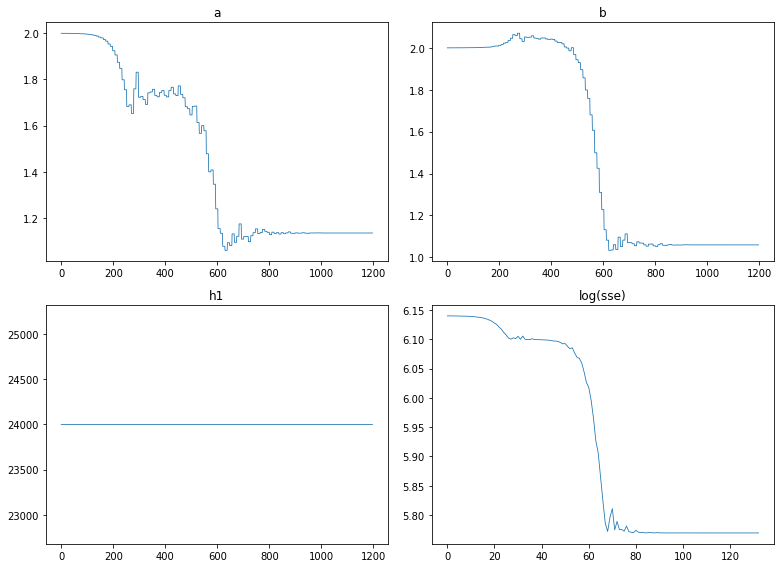

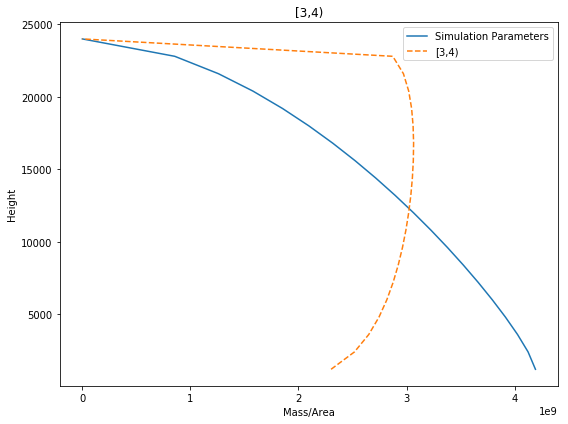

========LEFT OUT: (-337.0, 6683.0)========
a* = -2.02476	b* = -2.81144            	h0* = -1.52718	h1* = 1.49994
a = 1.13203	b = 1.06012	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 69
SSE: 315.7053828779727


,Height,Suspended Mass
0,1200.0,2.315262e+09
1,2400.0,2.528904e+09
2,3600.0,2.658818e+09
3,4800.0,2.751699e+09
4,6000.0,2.822998e+09
5,7200.0,2.879806e+09
6,8400.0,2.925951e+09
7,9600.0,2.963696e+09
8,10800.0,2.994438e+09
9,12000.0,3.019034e+09


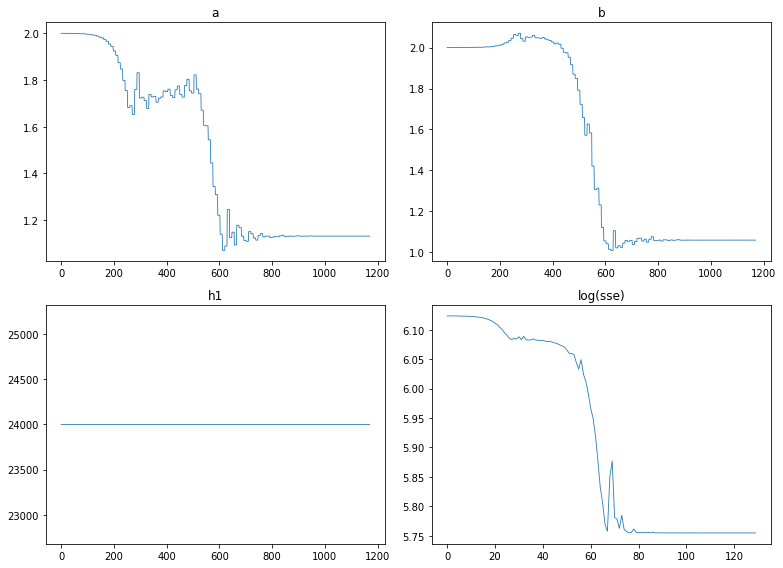

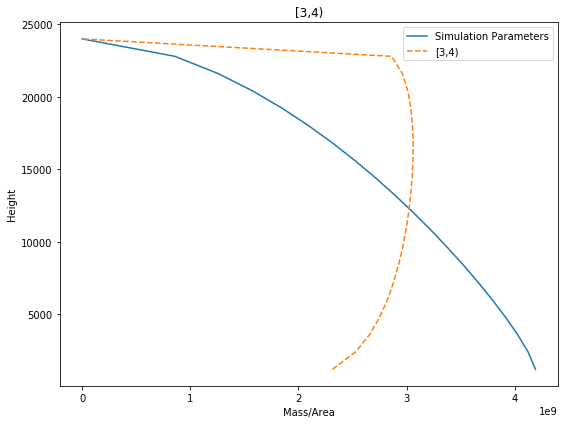

========LEFT OUT: (2519.0, 6318.0)========
a* = -2.00240	b* = -2.83188            	h0* = -1.52718	h1* = 1.49994
a = 1.13501	b = 1.05890	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 72
SSE: 317.5014652764669


,Height,Suspended Mass
0,1200.0,2.298130e+09
1,2400.0,2.515557e+09
2,3600.0,2.648173e+09
3,4800.0,2.743239e+09
4,6000.0,2.816415e+09
5,7200.0,2.874896e+09
6,8400.0,2.922570e+09
7,9600.0,2.961740e+09
8,10800.0,2.993831e+09
9,12000.0,3.019722e+09


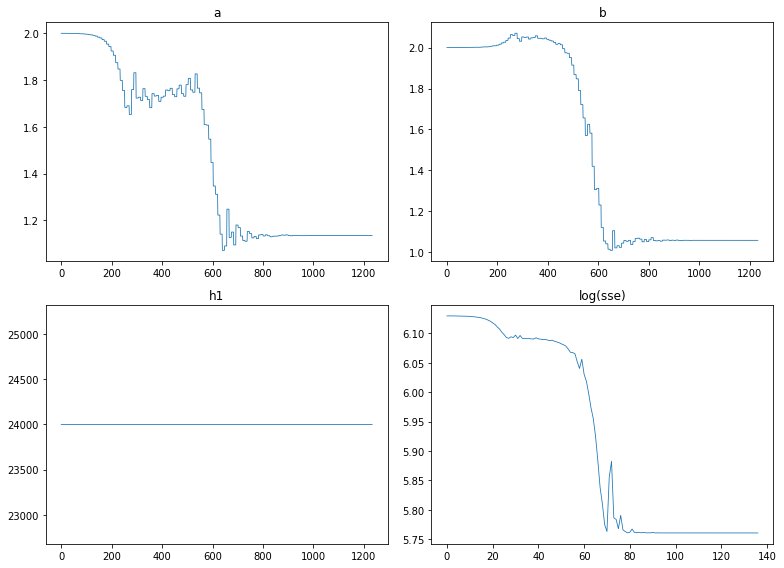

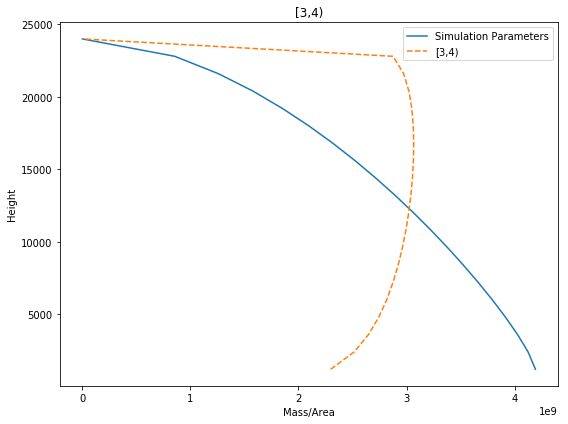

========LEFT OUT: (-1439.0, 6652.0)========
a* = -1.99856	b* = -2.83434            	h0* = -1.52718	h1* = 1.49994
a = 1.13553	b = 1.05876	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 68
SSE: 321.65532273000696


,Height,Suspended Mass
0,1200.0,2.295300e+09
1,2400.0,2.513383e+09
2,3600.0,2.646463e+09
3,4800.0,2.741901e+09
4,6000.0,2.815394e+09
5,7200.0,2.874155e+09
6,8400.0,2.922082e+09
7,9600.0,2.961485e+09
8,10800.0,2.993794e+09
9,12000.0,3.019891e+09


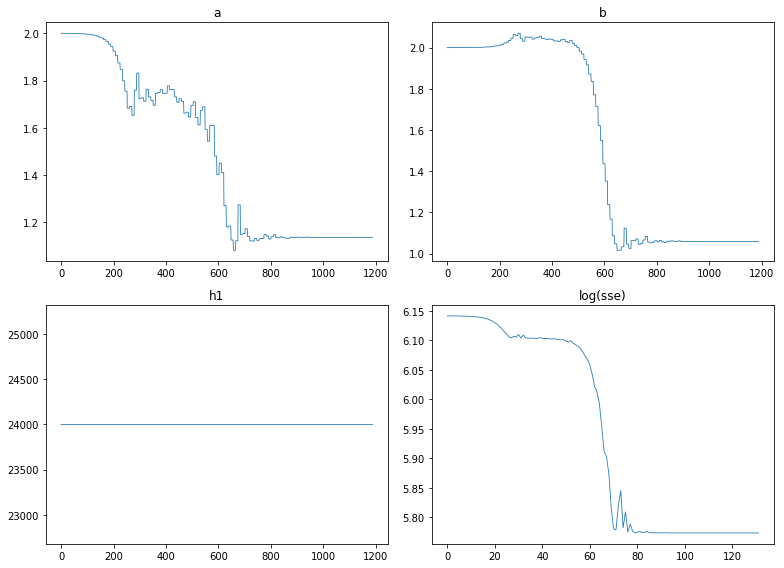

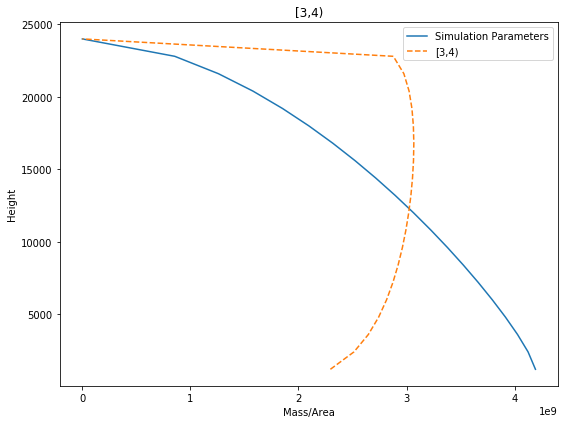

========LEFT OUT: (5823.0, 3944.0)========
a* = -1.99807	b* = -2.83467            	h0* = -1.52718	h1* = 1.49994
a = 1.13560	b = 1.05874	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 69
SSE: 321.60742170609086


,Height,Suspended Mass
0,1200.0,2.294938e+09
1,2400.0,2.513104e+09
2,3600.0,2.646244e+09
3,4800.0,2.741729e+09
4,6000.0,2.815263e+09
5,7200.0,2.874059e+09
6,8400.0,2.922018e+09
7,9600.0,2.961451e+09
8,10800.0,2.993788e+09
9,12000.0,3.019912e+09


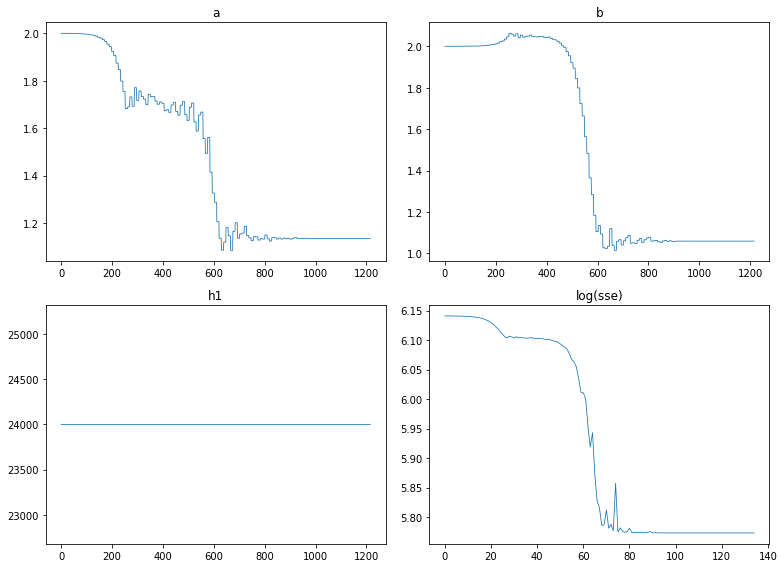

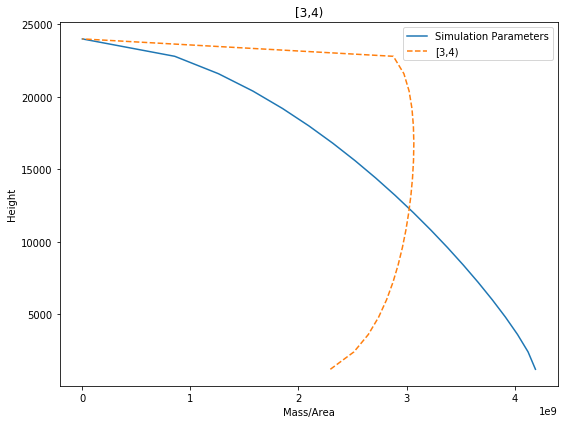

========LEFT OUT: (4688.0, 5396.0)========
a* = -2.00337	b* = -2.83160            	h0* = -1.52718	h1* = 1.49994
a = 1.13488	b = 1.05892	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 71
SSE: 319.5659991891726


,Height,Suspended Mass
0,1200.0,2.298802e+09
1,2400.0,2.516062e+09
2,3600.0,2.648562e+09
3,4800.0,2.743536e+09
4,6000.0,2.816634e+09
5,7200.0,2.875048e+09
6,8400.0,2.922662e+09
7,9600.0,2.961778e+09
8,10800.0,2.993819e+09
9,12000.0,3.019663e+09


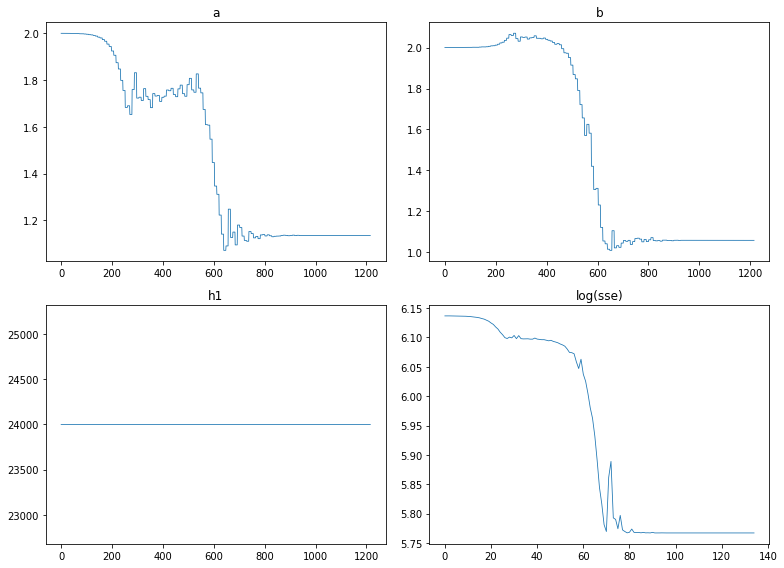

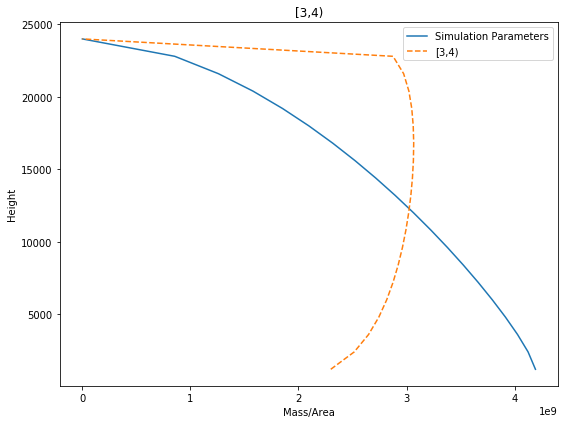

========LEFT OUT: (918.0, 7180.0)========
a* = -1.87198	b* = -2.84579            	h0* = -1.52718	h1* = 1.49994
a = 1.15382	b = 1.05809	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 66
SSE: 338.13514087417445


,Height,Suspended Mass
0,1200.0,2.206363e+09
1,2400.0,2.446907e+09
2,3600.0,2.595743e+09
3,4800.0,2.703649e+09
4,6000.0,2.787589e+09
5,7200.0,2.855405e+09
6,8400.0,2.911360e+09
7,9600.0,2.957991e+09
8,10800.0,2.996885e+09
9,12000.0,3.029033e+09


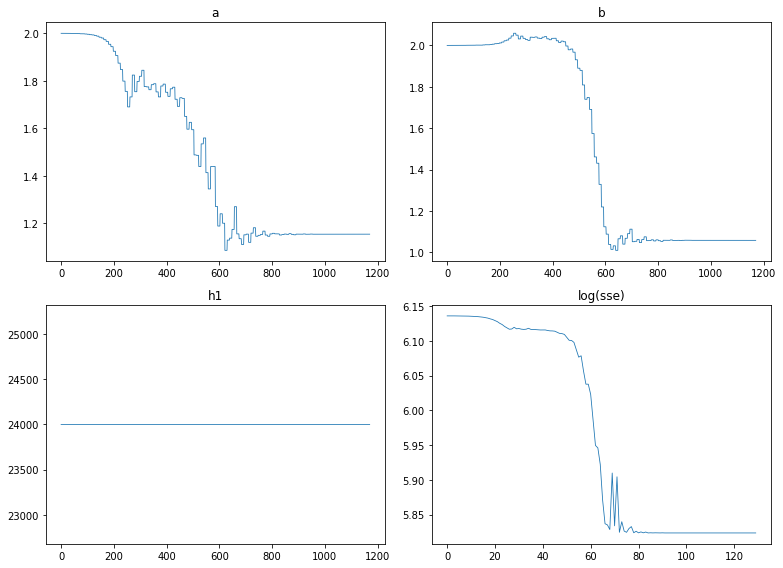

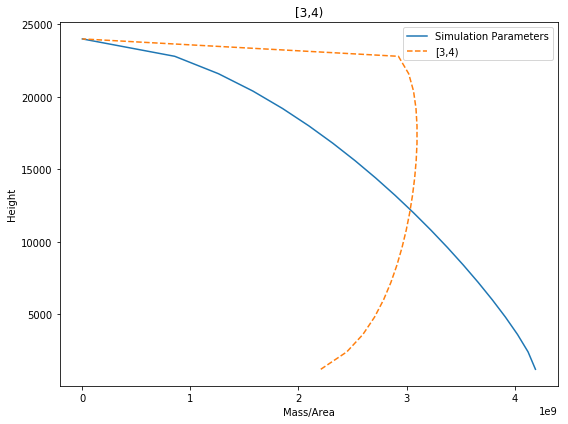

========LEFT OUT: (4337.0, 6035.0)========
a* = -2.06289	b* = -2.73044            	h0* = -1.52718	h1* = 1.49994
a = 1.12709	b = 1.06519	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 74
SSE: 329.7525772028562


,Height,Suspended Mass
0,1200.0,2.350267e+09
1,2400.0,2.557663e+09
2,3600.0,2.682896e+09
3,4800.0,2.771823e+09
4,6000.0,2.839581e+09
5,7200.0,2.893102e+09
6,8400.0,2.936119e+09
7,9600.0,2.970828e+09
8,10800.0,2.998574e+09
9,12000.0,3.020171e+09


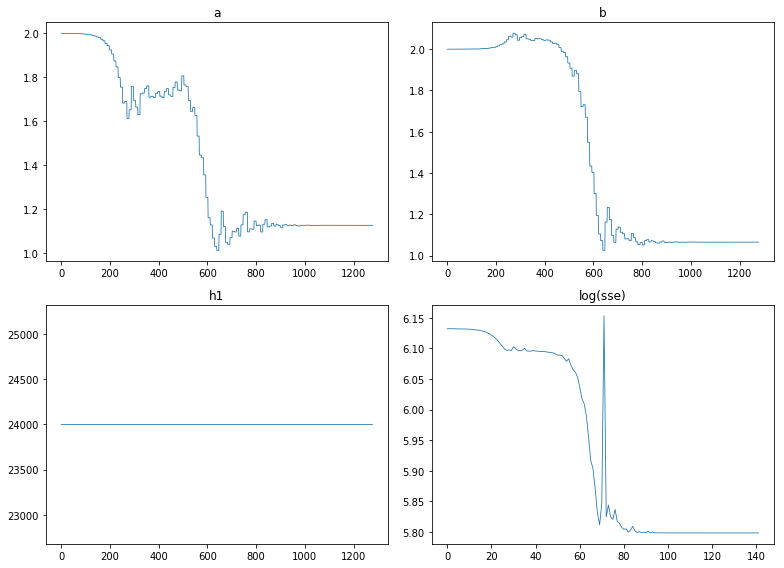

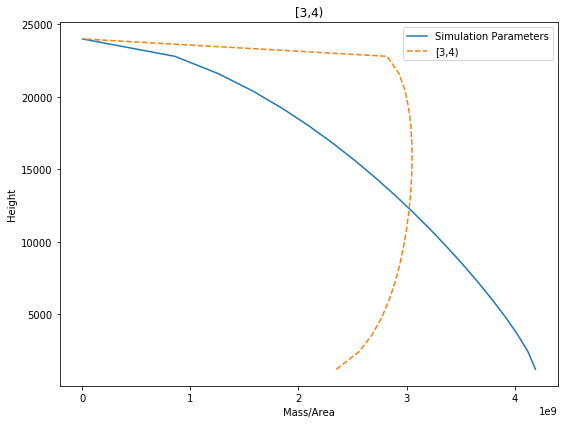

========LEFT OUT: (2019.0, 7255.0)========
a* = -2.01255	b* = -2.76666            	h0* = -1.52718	h1* = 1.49994
a = 1.13365	b = 1.06287	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 71
SSE: 330.53387868061134


,Height,Suspended Mass
0,1200.0,2.313031e+09
1,2400.0,2.528933e+09
2,3600.0,2.660179e+09
3,4800.0,2.753933e+09
4,6000.0,2.825811e+09
5,7200.0,2.882980e+09
6,8400.0,2.929311e+09
7,9600.0,2.967088e+09
8,10800.0,2.997720e+09
9,12000.0,3.022066e+09


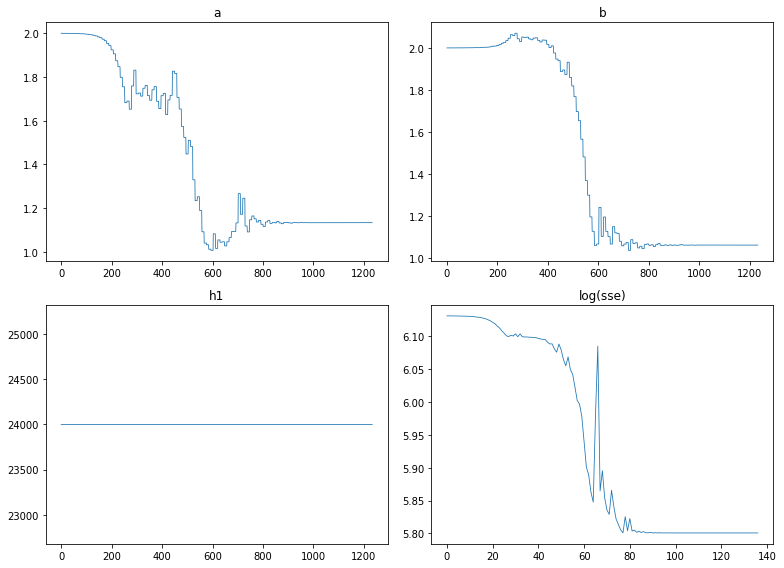

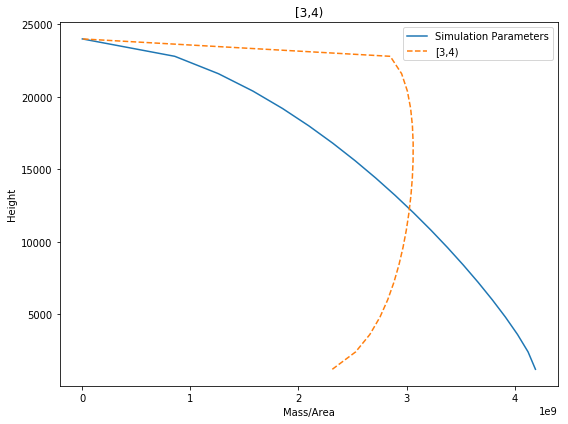

========LEFT OUT: (-586.0, 7588.0)========
a* = -2.00087	b* = -2.83342            	h0* = -1.52718	h1* = 1.49994
a = 1.13522	b = 1.05881	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 71
SSE: 318.035571282174


,Height,Suspended Mass
0,1200.0,2.296936e+09
1,2400.0,2.514622e+09
2,3600.0,2.647424e+09
3,4800.0,2.742641e+09
4,6000.0,2.815947e+09
5,7200.0,2.874544e+09
6,8400.0,2.922325e+09
7,9600.0,2.961595e+09
8,10800.0,2.993781e+09
9,12000.0,3.019763e+09


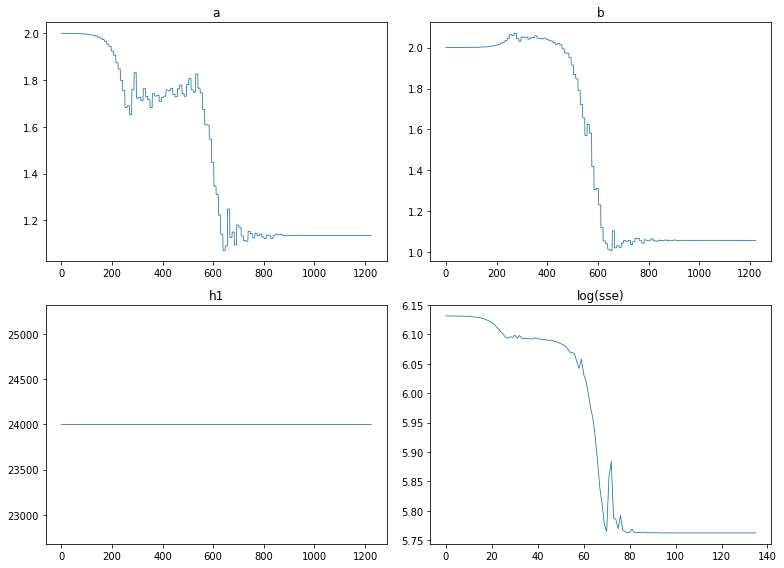

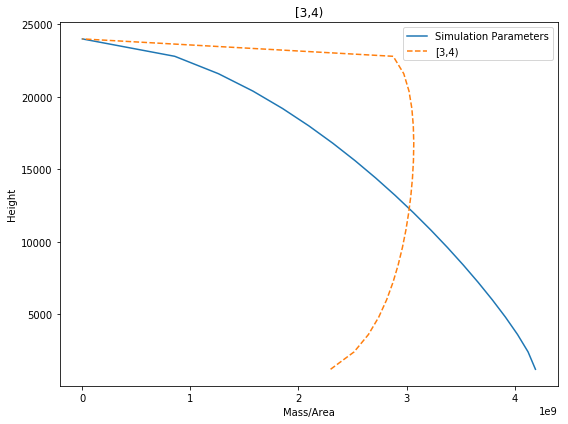

========LEFT OUT: (-387.0, 7656.0)========
a* = -2.01809	b* = -2.81430            	h0* = -1.52718	h1* = 1.49994
a = 1.13291	b = 1.05995	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 67
SSE: 319.7942784105966


,Height,Suspended Mass
0,1200.0,2.310572e+09
1,2400.0,2.525351e+09
2,3600.0,2.656060e+09
3,4800.0,2.749572e+09
4,6000.0,2.821403e+09
5,7200.0,2.878676e+09
6,8400.0,2.925239e+09
7,9600.0,2.963365e+09
8,10800.0,2.994460e+09
9,12000.0,3.019387e+09


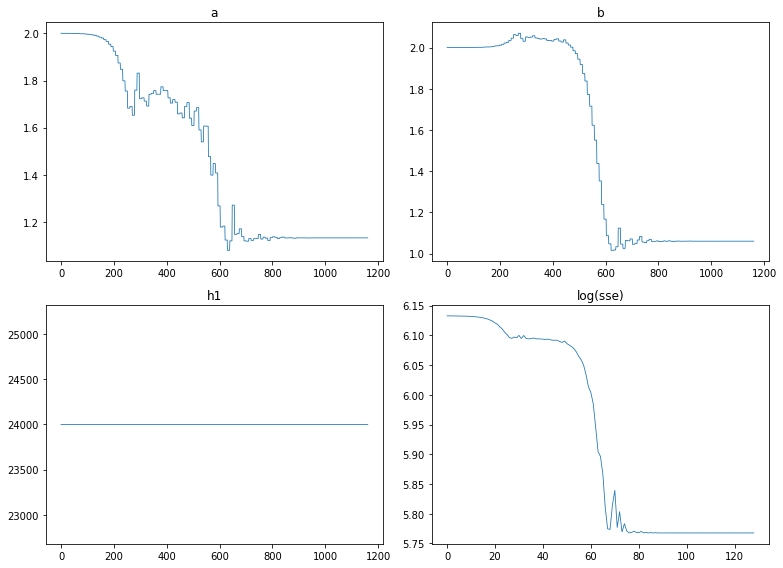

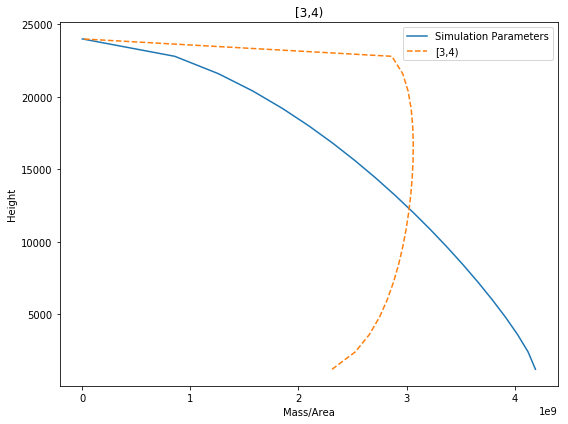

========LEFT OUT: (-555.0, 7666.0)========
a* = -2.06394	b* = -2.78575            	h0* = -1.52718	h1* = 1.49994
a = 1.12695	b = 1.06168	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 70
SSE: 314.6267000760195


,Height,Suspended Mass
0,1200.0,2.343558e+09
1,2400.0,2.550612e+09
2,3600.0,2.675892e+09
3,4800.0,2.765069e+09
4,6000.0,2.833219e+09
5,7200.0,2.887250e+09
6,8400.0,2.930881e+09
7,9600.0,2.966308e+09
8,10800.0,2.994880e+09
9,12000.0,3.017416e+09


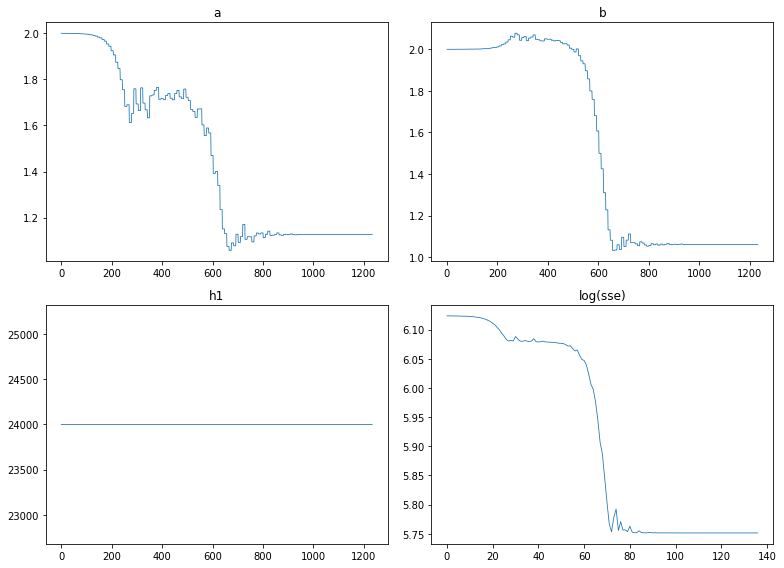

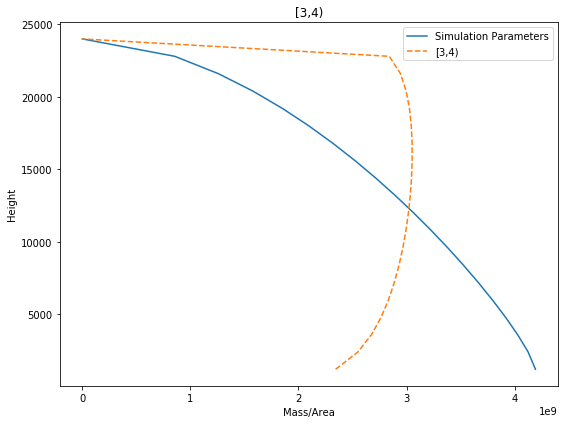

========LEFT OUT: (3512.0, 6869.0)========
a* = -2.06118	b* = -2.78825            	h0* = -1.52718	h1* = 1.49994
a = 1.12730	b = 1.06153	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 69
SSE: 314.2520027880244


,Height,Suspended Mass
0,1200.0,2.341501e+09
1,2400.0,2.549012e+09
2,3600.0,2.674617e+09
3,4800.0,2.764055e+09
4,6000.0,2.832430e+09
5,7200.0,2.886660e+09
6,8400.0,2.930474e+09
7,9600.0,2.966071e+09
8,10800.0,2.994803e+09
9,12000.0,3.017495e+09


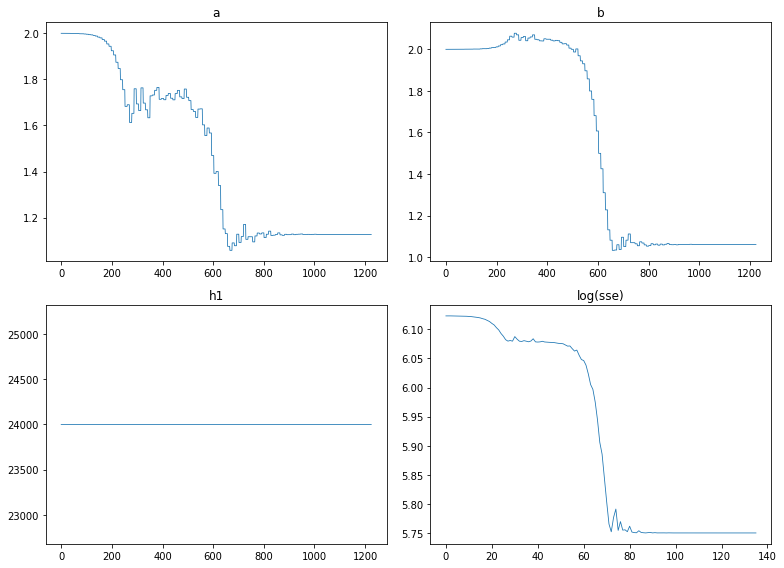

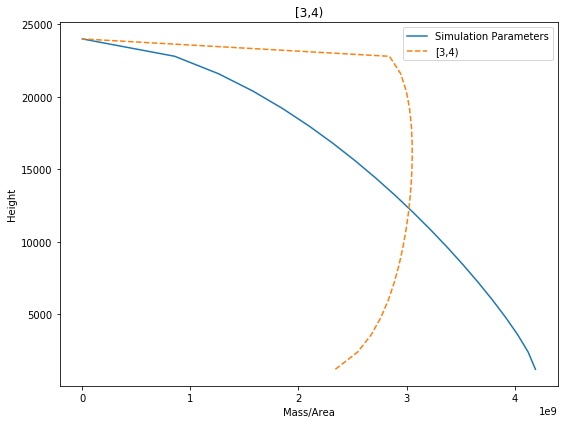

========LEFT OUT: (3226.0, 7110.0)========
a* = -2.02601	b* = -2.81303            	h0* = -1.52718	h1* = 1.49994
a = 1.13186	b = 1.06002	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 68
SSE: 316.41149333212456


,Height,Suspended Mass
0,1200.0,2.315870e+09
1,2400.0,2.529293e+09
2,3600.0,2.659064e+09
3,4800.0,2.751839e+09
4,6000.0,2.823056e+09
5,7200.0,2.879797e+09
6,8400.0,2.925889e+09
7,9600.0,2.963590e+09
8,10800.0,2.994298e+09
9,12000.0,3.018868e+09


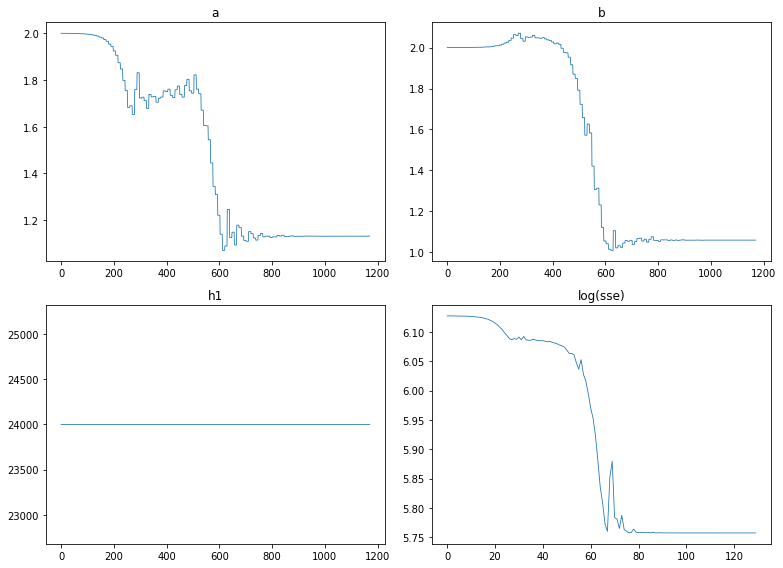

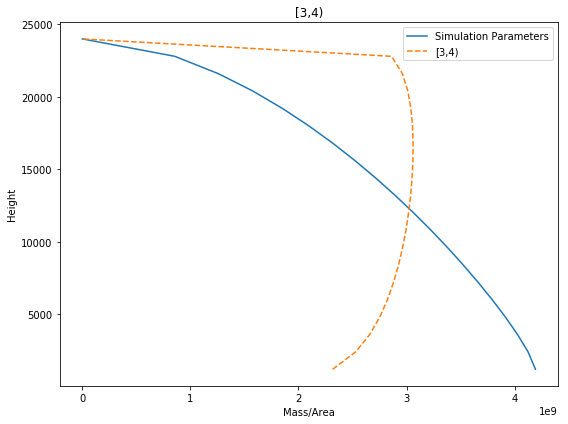

========LEFT OUT: (1154.0, 7735.0)========
a* = -2.03607	b* = -2.80550            	h0* = -1.52718	h1* = 1.49994
a = 1.13054	b = 1.06048	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 69
SSE: 315.7702609663777


,Height,Suspended Mass
0,1200.0,2.323305e+09
1,2400.0,2.535031e+09
2,3600.0,2.663601e+09
3,4800.0,2.755412e+09
4,6000.0,2.825806e+09
5,7200.0,2.881819e+09
6,8400.0,2.927248e+09
7,9600.0,2.964337e+09
8,10800.0,2.994469e+09
9,12000.0,3.018490e+09


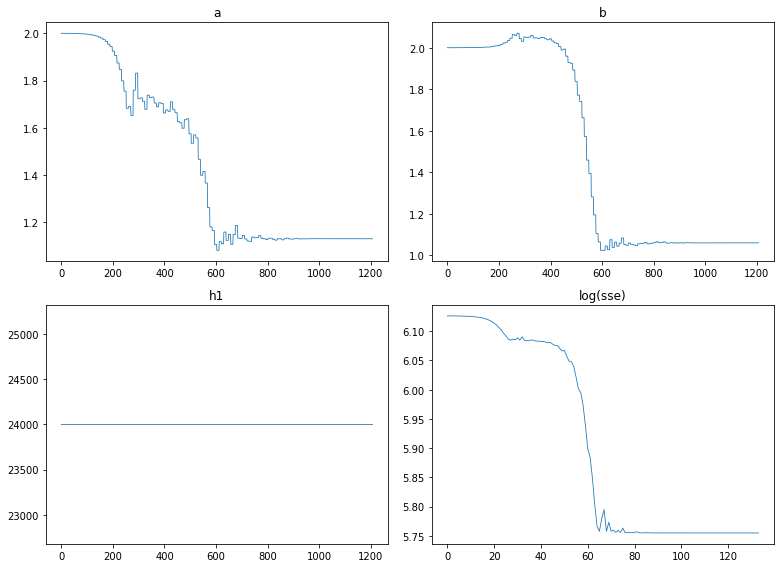

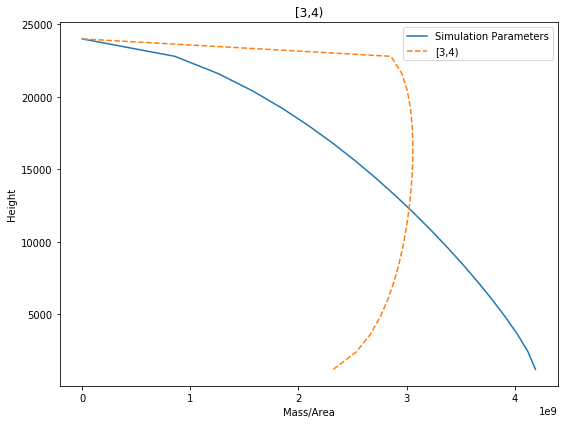

========LEFT OUT: (2037.0, 7565.0)========
a* = -2.01814	b* = -2.81933            	h0* = -1.52718	h1* = 1.49994
a = 1.13290	b = 1.05965	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 70
SSE: 317.04455121675386


,Height,Suspended Mass
0,1200.0,2.309983e+09
1,2400.0,2.524735e+09
2,3600.0,2.655450e+09
3,4800.0,2.748985e+09
4,6000.0,2.820851e+09
5,7200.0,2.878169e+09
6,8400.0,2.924785e+09
7,9600.0,2.962974e+09
8,10800.0,2.994140e+09
9,12000.0,3.019148e+09


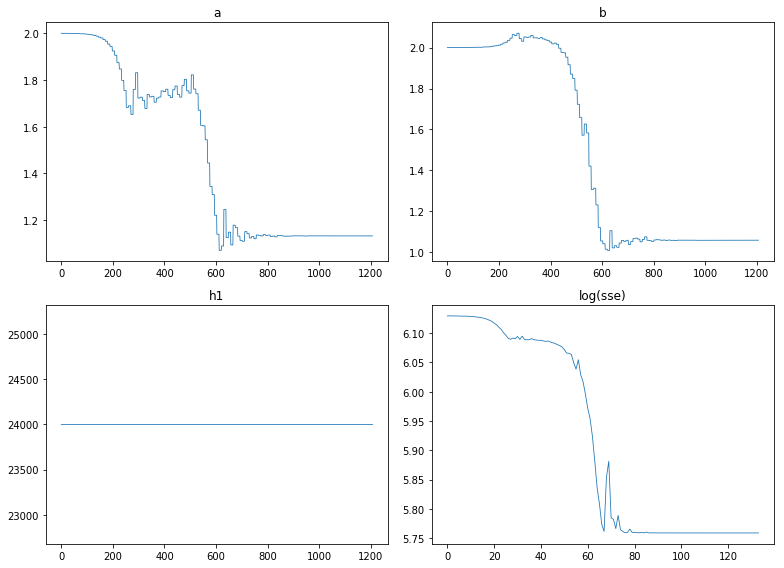

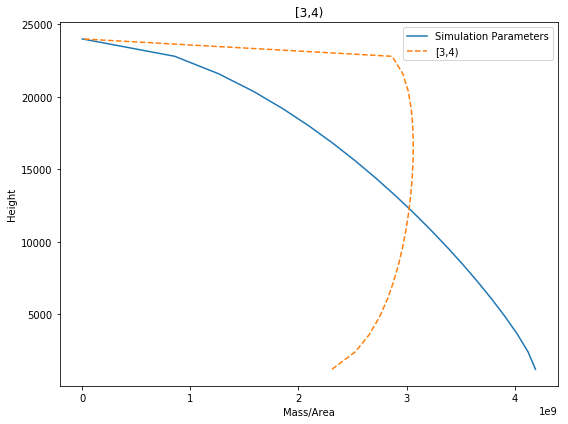

========LEFT OUT: (3352.0, 7167.0)========
a* = -2.02748	b* = -2.81220            	h0* = -1.52718	h1* = 1.49994
a = 1.13167	b = 1.06007	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 70
SSE: 316.3876181008202


,Height,Suspended Mass
0,1200.0,2.316927e+09
1,2400.0,2.530101e+09
2,3600.0,2.659696e+09
3,4800.0,2.752332e+09
4,6000.0,2.823429e+09
5,7200.0,2.880066e+09
6,8400.0,2.926064e+09
7,9600.0,2.963679e+09
8,10800.0,2.994306e+09
9,12000.0,3.018800e+09


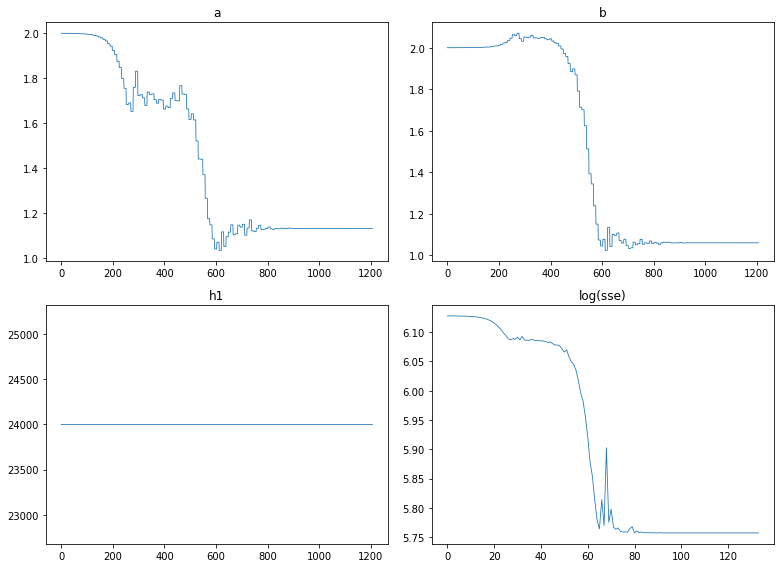

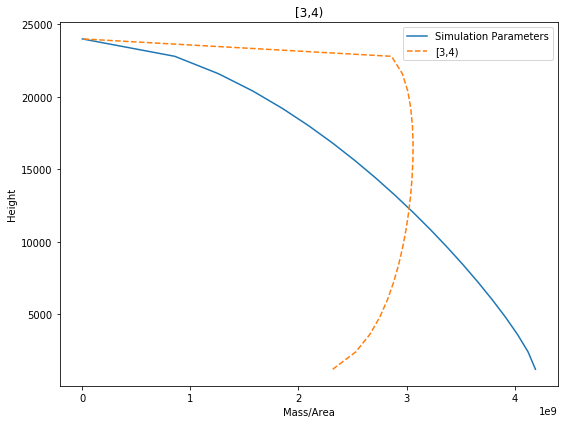

========LEFT OUT: (3066.0, 7419.0)========
a* = -2.00235	b* = -2.83233            	h0* = -1.52718	h1* = 1.49994
a = 1.13502	b = 1.05888	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 70
SSE: 318.31633765145136


,Height,Suspended Mass
0,1200.0,2.298044e+09
1,2400.0,2.515478e+09
2,3600.0,2.648100e+09
3,4800.0,2.743173e+09
4,6000.0,2.816356e+09
5,7200.0,2.874844e+09
6,8400.0,2.922526e+09
7,9600.0,2.961704e+09
8,10800.0,2.993804e+09
9,12000.0,3.019704e+09


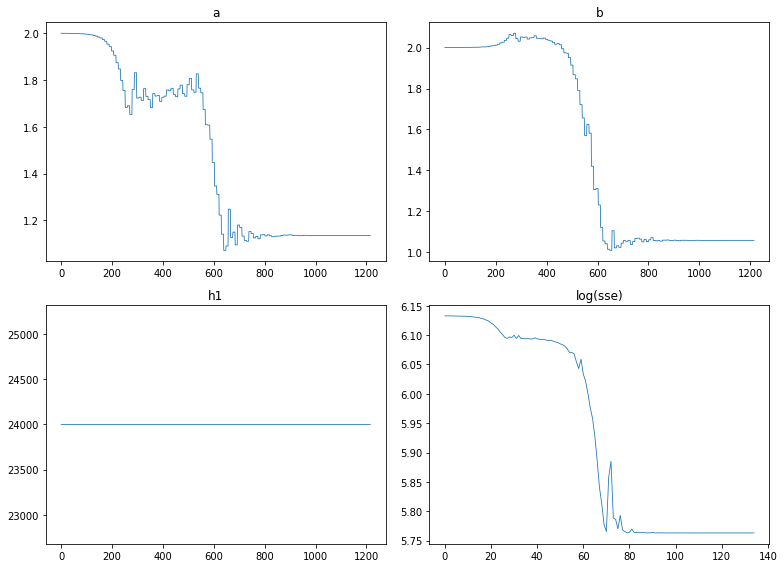

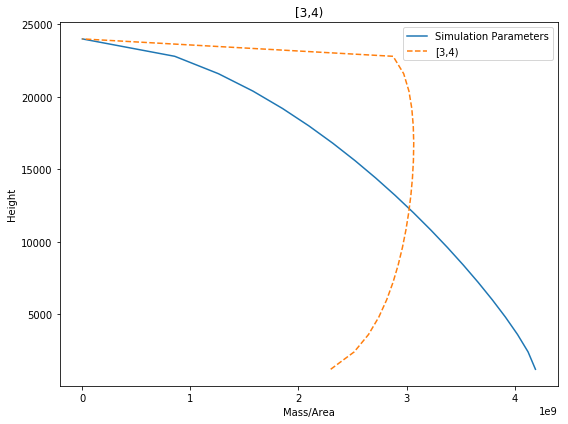

========LEFT OUT: (2287.0, 7844.0)========
a* = -1.99351	b* = -2.83969            	h0* = -1.52718	h1* = 1.49994
a = 1.13622	b = 1.05844	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 76
SSE: 320.07682334034786


,Height,Suspended Mass
0,1200.0,2.291314e+09
1,2400.0,2.510253e+09
2,3600.0,2.643950e+09
3,4800.0,2.739890e+09
4,6000.0,2.813816e+09
5,7200.0,2.872965e+09
6,8400.0,2.921249e+09
7,9600.0,2.960986e+09
8,10800.0,2.993613e+09
9,12000.0,3.020017e+09


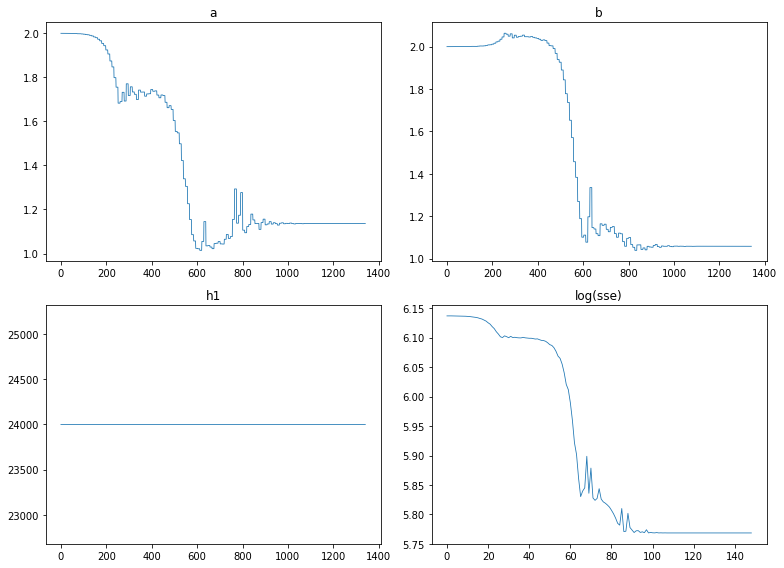

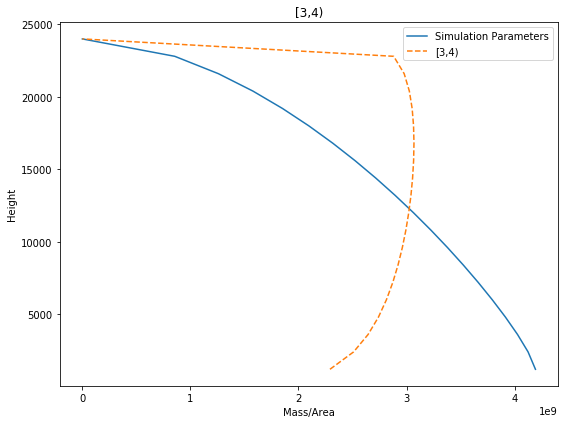

========LEFT OUT: (1907.0, 8096.0)========
a* = -1.99879	b* = -2.83384            	h0* = -1.52718	h1* = 1.49994
a = 1.13550	b = 1.05879	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 69
SSE: 321.8529935811406


,Height,Suspended Mass
0,1200.0,2.295512e+09
1,2400.0,2.513557e+09
2,3600.0,2.646608e+09
3,4800.0,2.742023e+09
4,6000.0,2.815494e+09
5,7200.0,2.874234e+09
6,8400.0,2.922142e+09
7,9600.0,2.961527e+09
8,10800.0,2.993818e+09
9,12000.0,3.019897e+09


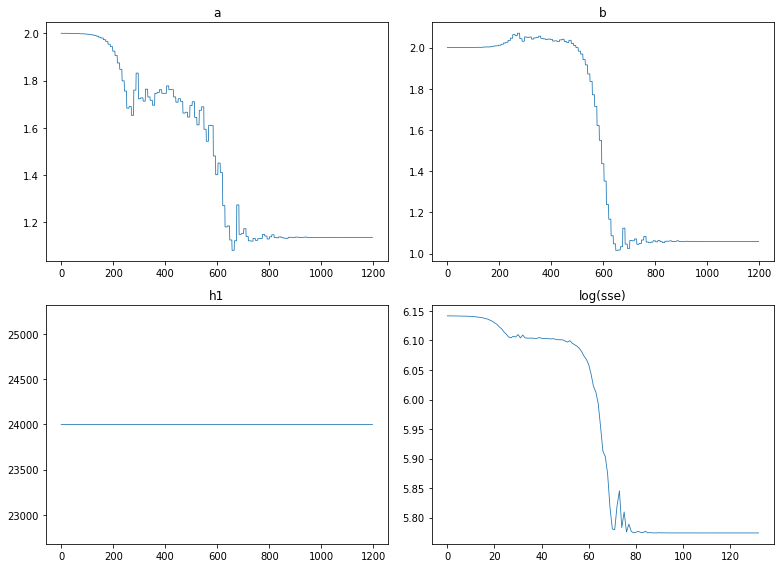

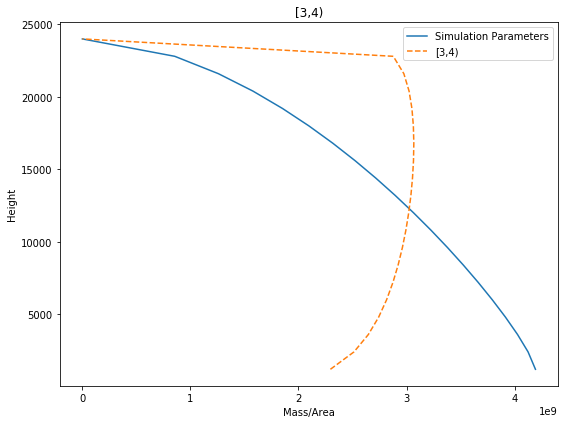

========LEFT OUT: (225.0, 8480.0)========
a* = -2.00008	b* = -2.83222            	h0* = -1.52718	h1* = 1.49994
a = 1.13533	b = 1.05888	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 71
SSE: 322.341499990302


,Height,Suspended Mass
0,1200.0,2.296558e+09
1,2400.0,2.514386e+09
2,3600.0,2.647280e+09
3,4800.0,2.742565e+09
4,6000.0,2.815924e+09
5,7200.0,2.874563e+09
6,8400.0,2.922378e+09
7,9600.0,2.961674e+09
8,10800.0,2.993880e+09
9,12000.0,3.019877e+09


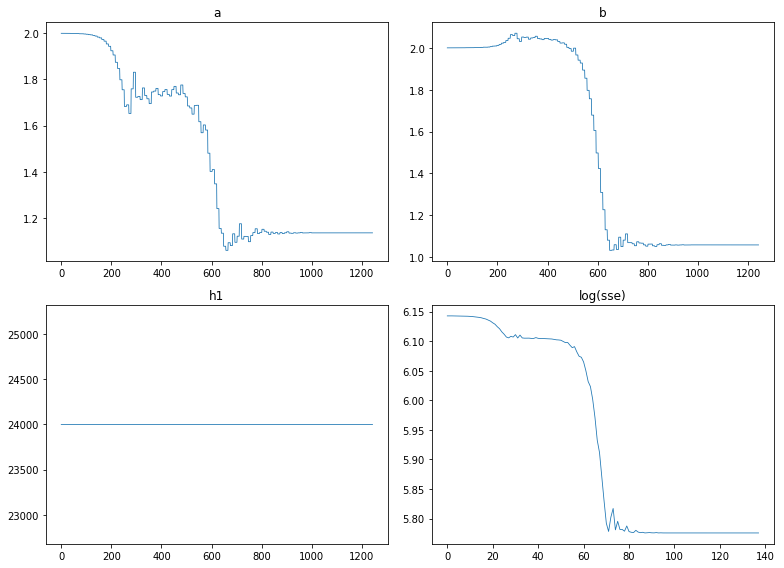

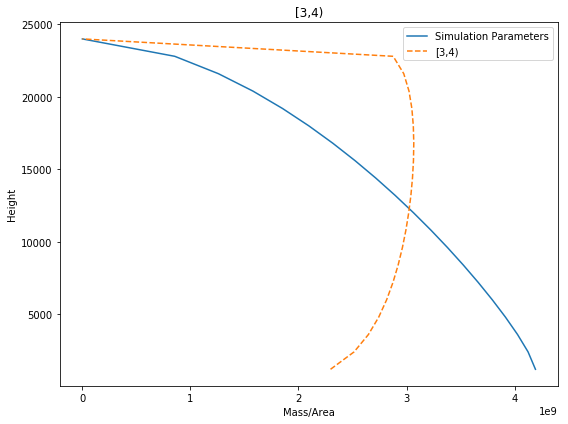

========LEFT OUT: (2424.0, 8963.0)========
a* = -1.99033	b* = -2.84109            	h0* = -1.52718	h1* = 1.49994
a = 1.13665	b = 1.05836	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 75
SSE: 319.01844770203917


,Height,Suspended Mass
0,1200.0,2.289029e+09
1,2400.0,2.508518e+09
2,3600.0,2.642601e+09
3,4800.0,2.738848e+09
4,6000.0,2.813034e+09
5,7200.0,2.872410e+09
6,8400.0,2.920898e+09
7,9600.0,2.960822e+09
8,10800.0,2.993622e+09
9,12000.0,3.020188e+09


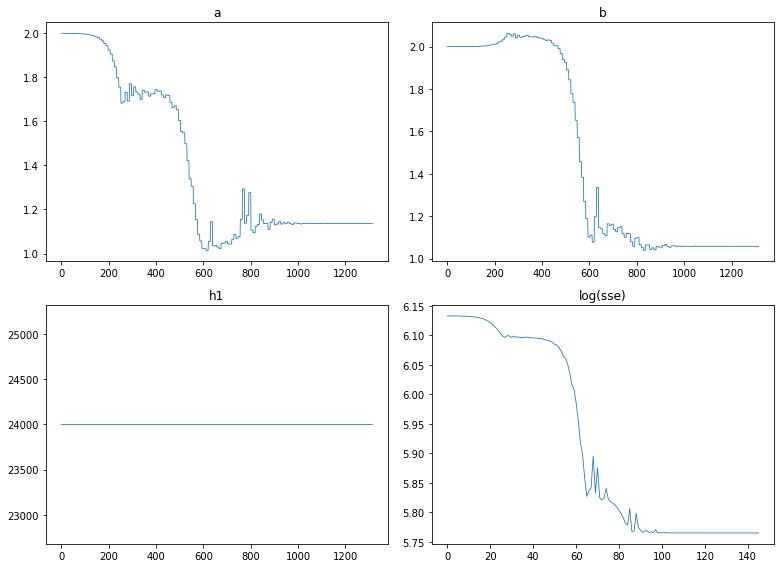

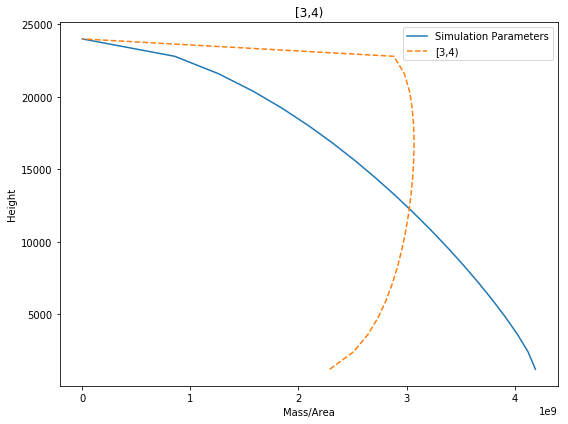

========LEFT OUT: (2665.0, 9054.0)========
a* = -2.00261	b* = -2.82907            	h0* = -1.52718	h1* = 1.49994
a = 1.13498	b = 1.05907	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 71
SSE: 323.0875388816986


,Height,Suspended Mass
0,1200.0,2.298612e+09
1,2400.0,2.516012e+09
2,3600.0,2.648596e+09
3,4800.0,2.743628e+09
4,6000.0,2.816766e+09
5,7200.0,2.875206e+09
6,8400.0,2.922837e+09
7,9600.0,2.961960e+09
8,10800.0,2.994000e+09
9,12000.0,3.019836e+09


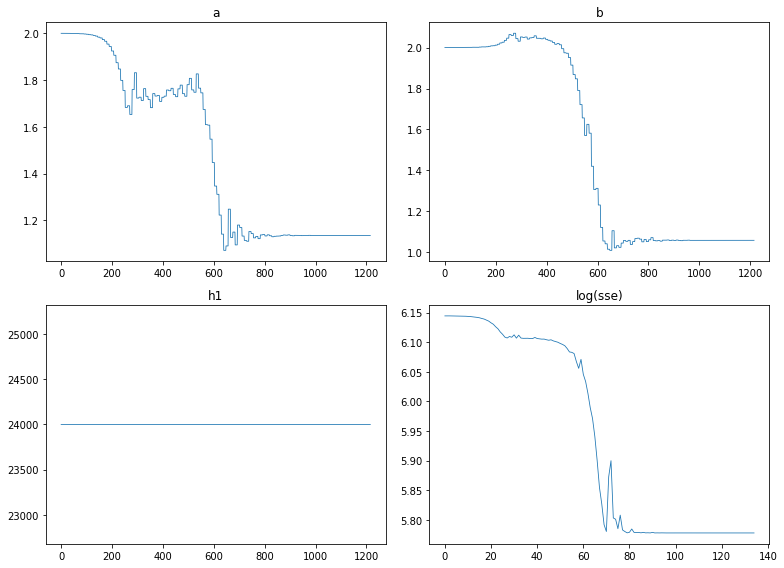

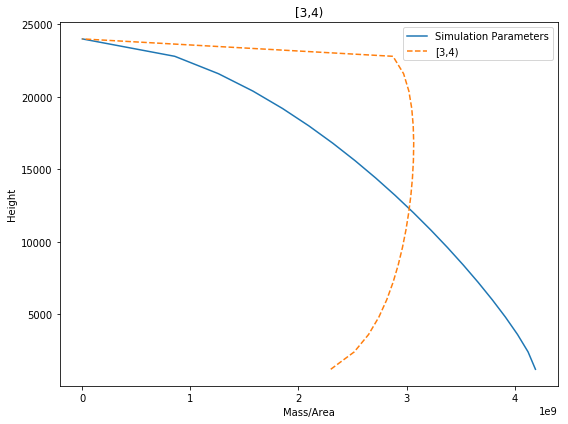

========LEFT OUT: (2979.0, 9056.0)========
a* = -2.00220	b* = -2.82958            	h0* = -1.52718	h1* = 1.49994
a = 1.13504	b = 1.05904	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 73
SSE: 322.983625334184


,Height,Suspended Mass
0,1200.0,2.298276e+09
1,2400.0,2.515747e+09
2,3600.0,2.648382e+09
3,4800.0,2.743454e+09
4,6000.0,2.816629e+09
5,7200.0,2.875102e+09
6,8400.0,2.922762e+09
7,9600.0,2.961914e+09
8,10800.0,2.993981e+09
9,12000.0,3.019843e+09


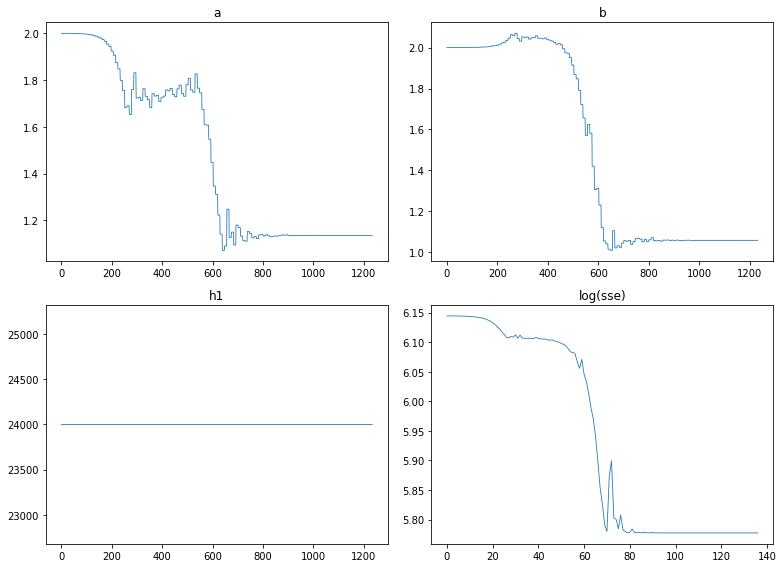

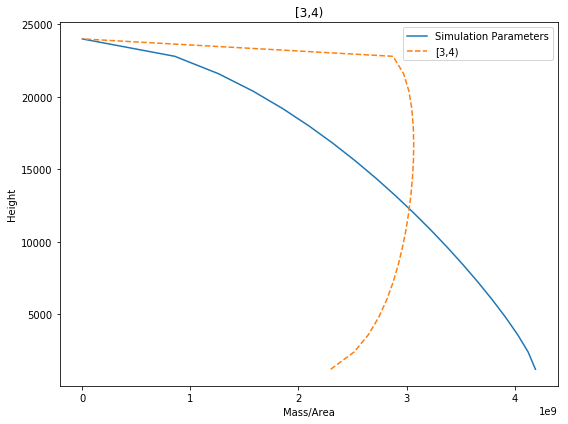

========LEFT OUT: (3133.0, 9522.0)========
a* = -2.00076	b* = -2.83125            	h0* = -1.52718	h1* = 1.49994
a = 1.13523	b = 1.05894	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 70
SSE: 322.60516191501586


,Height,Suspended Mass
0,1200.0,2.297131e+09
1,2400.0,2.514842e+09
2,3600.0,2.647652e+09
3,4800.0,2.742868e+09
4,6000.0,2.816166e+09
5,7200.0,2.874750e+09
6,8400.0,2.922513e+09
7,9600.0,2.961761e+09
8,10800.0,2.993920e+09
9,12000.0,3.019871e+09


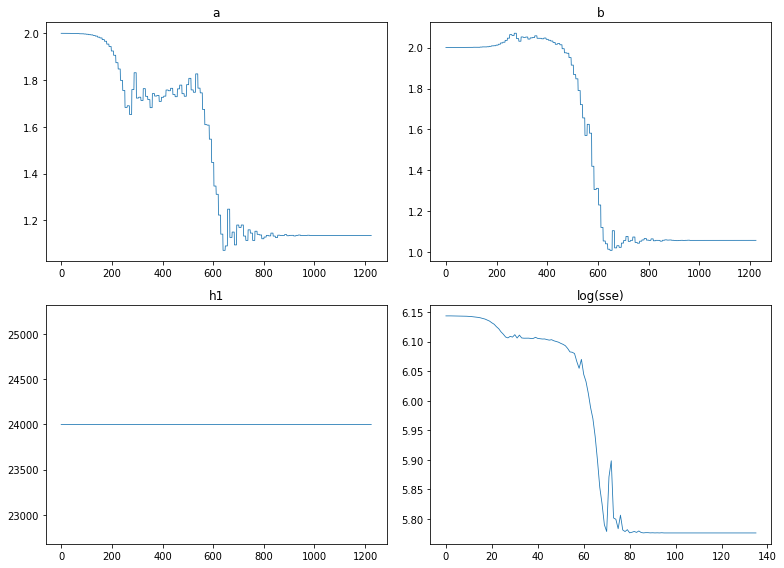

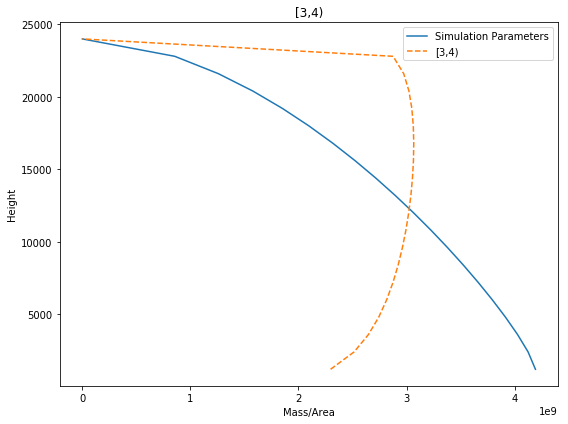

========LEFT OUT: (5500.0, 8723.0)========
a* = -1.99183	b* = -2.84109            	h0* = -1.52718	h1* = 1.49994
a = 1.13645	b = 1.05836	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 76
SSE: 319.87109491523967


,Height,Suspended Mass
0,1200.0,2.290030e+09
1,2400.0,2.509257e+09
2,3600.0,2.643158e+09
3,4800.0,2.739264e+09
4,6000.0,2.813332e+09
5,7200.0,2.872607e+09
6,8400.0,2.921005e+09
7,9600.0,2.960849e+09
8,10800.0,2.993577e+09
9,12000.0,3.020077e+09


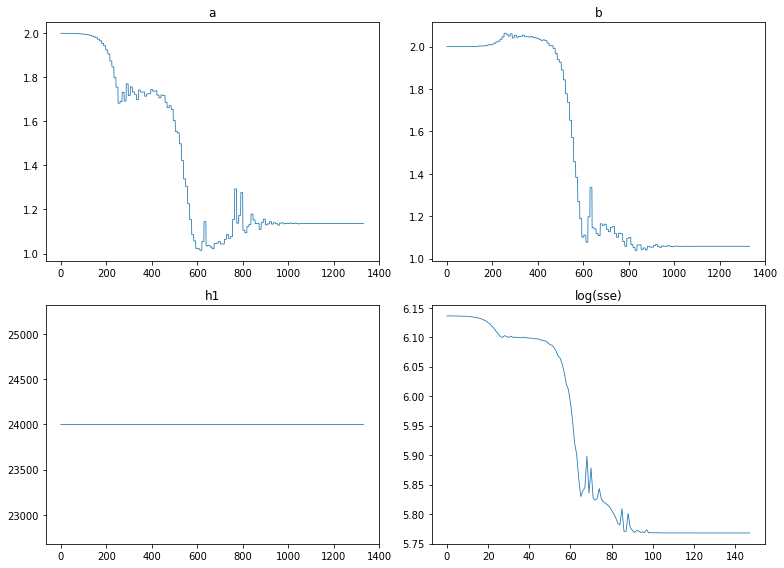

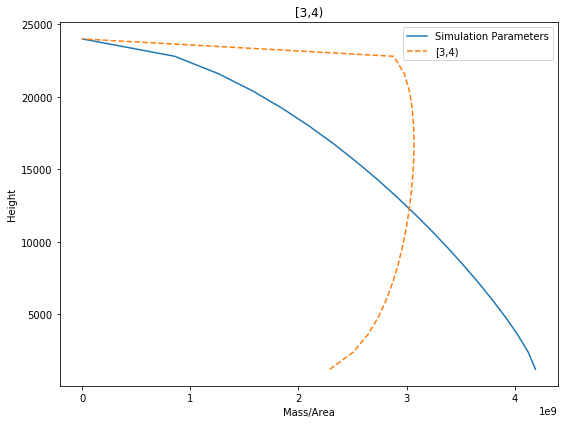

========LEFT OUT: (4617.0, 10199.0)========
a* = -1.98617	b* = -2.84630            	h0* = -1.52718	h1* = 1.49994
a = 1.13722	b = 1.05806	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 75
SSE: 317.0642751883792


,Height,Suspended Mass
0,1200.0,2.285639e+09
1,2400.0,2.505832e+09
2,3600.0,2.640426e+09
3,4800.0,2.737093e+09
4,6000.0,2.811644e+09
5,7200.0,2.871348e+09
6,8400.0,2.920140e+09
7,9600.0,2.960351e+09
8,10800.0,2.993425e+09
9,12000.0,3.020258e+09


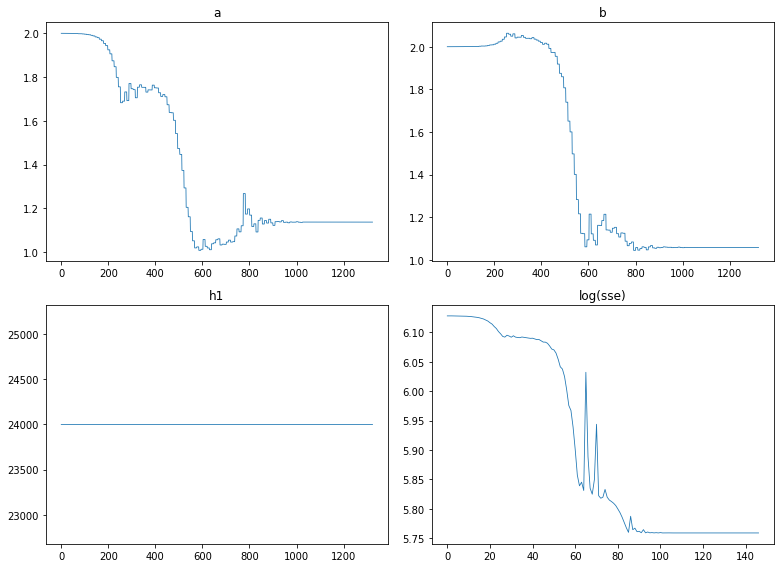

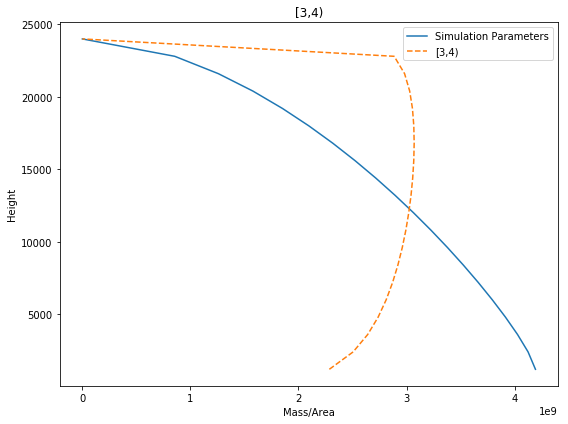

========LEFT OUT: (5132.0, 11365.0)========
a* = -1.99711	b* = -2.83095            	h0* = -1.52718	h1* = 1.49994
a = 1.13573	b = 1.05896	h0 = 0.01000	h1 = 24000.00000
Success: True, Optimization terminated successfully.
Iterations: 75
SSE: 314.4184589860172


,Height,Suspended Mass
0,1200.0,2.294753e+09
1,2400.0,2.513100e+09
2,3600.0,2.646347e+09
3,4800.0,2.741903e+09
4,6000.0,2.815483e+09
5,7200.0,2.874309e+09
6,8400.0,2.922284e+09
7,9600.0,2.961721e+09
8,10800.0,2.994050e+09
9,12000.0,3.020155e+09


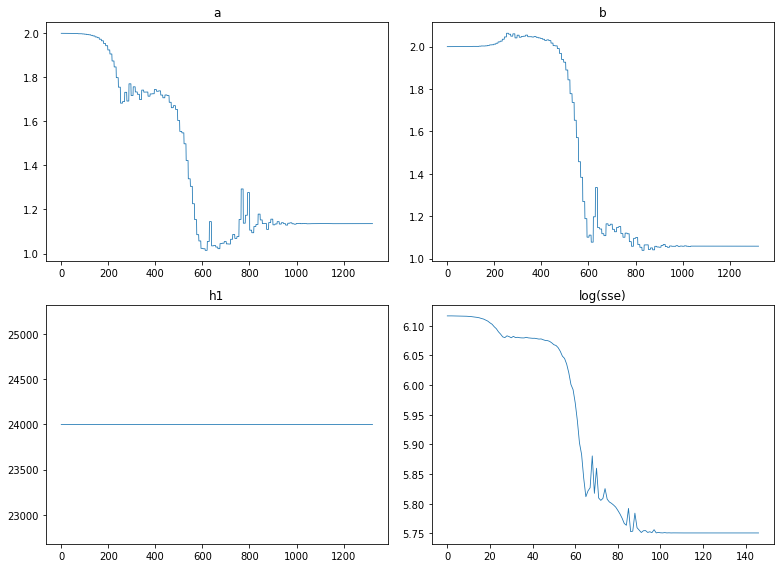

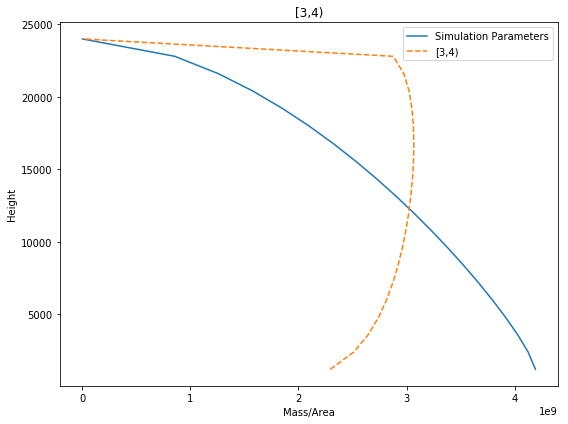

In [49]:
df = t2_df

priors_vals = {
    "a": 2,
    "b": 2,
    "h0": 0.01,
    "h1": 24000
}

invert_params = {
        "a" : True,
        "b" : True,
        "h0" : False,
        "h1" : False
    }

H = 30000

wind_angle = np.radians(55.5)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []
sse_list = []
for i in range(len(df)):
    loo_df = df.copy()
    loo_df = loo_df.drop(index=i)
    row = df.iloc[i]
    print("========LEFT OUT: (%s, %s)========"%(str(row["Easting"]),
                                                str(row["Northing"])))
    out = gaussian_stack_inversion(config, 
                              globs, loo_df, 
                              len(loo_df), 
                              20, 0, 
                              config["PLUME_HEIGHT"], 
                              config["ERUPTION_MASS"],
                              (u,v),
                              phi_steps,
                              invert_params=invert_params,
                              priors = priors_vals, 
                              column_cap=H)
    inversion_table, _, _, _, params, sol, sse, trace, sse_trace = out
    inv_mass, _, _, _, _ = beta_transform(*param_inv_transform(*params.values(), H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    sse_list += [sse]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,3], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    
    plt.tight_layout()
    plt.show()
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_dist = beta(config["ALPHA"],config["BETA"])

    q_mass = mass_dist_in_plume(q_dist, 0, 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"], 
                                config["ERUPTION_MASS"])

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
    
    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()

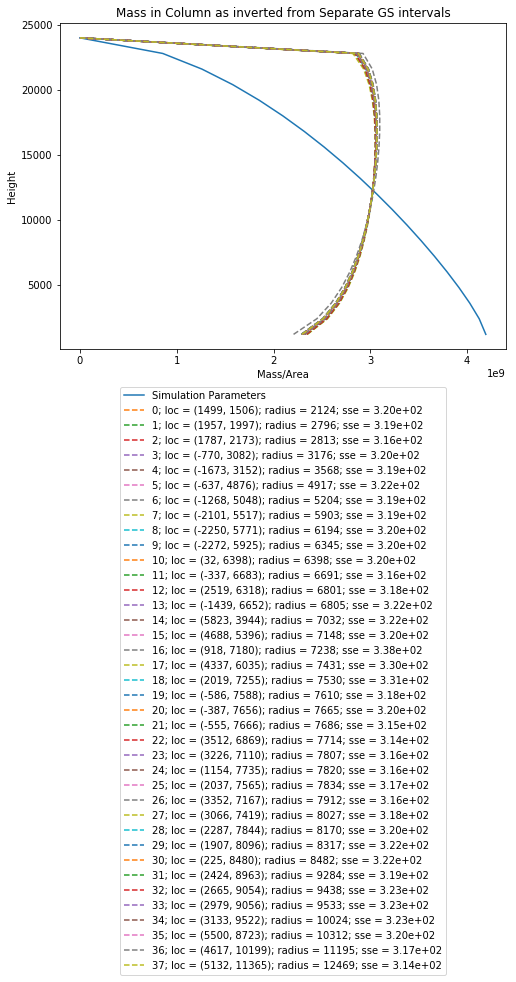

In [50]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    

q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = mass_dist_in_plume(q_dist, 0, 
                            config["PLUME_HEIGHT"], 
                            inversion_table["Height"], 
                            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for i, mass, sse in zip(range(len(df)), inverted_masses_list, sse_list):
    row=df.iloc[i]
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label="%d; loc = (%d, %d); radius = %d; sse = %.2e"%(
             i, 
             row["Easting"], 
             row["Northing"], 
             row["radius"],
             sse))

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

# plt.tight_layout()
plt.show()